
# Deep Neural Networks

## Overview

I will implement two types of deep learning network (fully connected and convolutional neural networks) to classify images of hands in poses corresponding to letters in American Sign Language. 

## Initialise environment

In [1]:
# libraries
import sys
assert sys.version_info >= (3, 5)
import time

# Scikit-Learn 
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os, time 
import pandas as pd
import functools

# Deep Learning imports
import tensorflow as tf
from tensorflow import keras

# Figure imports
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rc('figure', dpi=100)
import seaborn as sns; sns.set()

# Check the versions
print(tf.__version__)
print(keras.__version__)

# to get same results when we run everytime
from numpy.random import seed
seed(1)
tf.random.set_seed(2)

2.2.0
2.3.0-tf


---

## 1. Exploring the Dataset

#### Load the data


In [88]:
# import data from csv
train = pd.read_csv("sign_mnist_train.csv").values
test = pd.read_csv("sign_mnist_test.csv").values

In [89]:
# check shape of data
print("Training data shape: ",train.shape)
print()
print("Testing data shape: ",test.shape)

Training data shape:  (27455, 785)

Testing data shape:  (7172, 785)


In [90]:
train

array([[  3, 107, 118, ..., 204, 203, 202],
       [  6, 155, 157, ..., 103, 135, 149],
       [  2, 187, 188, ..., 195, 194, 195],
       ...,
       [ 18, 174, 174, ..., 202, 200, 200],
       [ 17, 177, 181, ...,  64,  87,  93],
       [ 23, 179, 180, ..., 205, 209, 215]])

In [91]:
# set up and reshape training data 
X_train_full = train[:, 1:].reshape(train.shape[0],28, 28).astype('float64')
y_train_full = train[:,0]

# set up reshape testing data 
X_test_full = test[:, 1:].reshape(test.shape[0],28, 28).astype('float64')
y_test_full = test[:,0]

Some descriptive information about the dataset

In [92]:
# check shape of data
print("Training data shape: ",X_train_full.shape)
print("Training data shape: ",y_train_full.shape)
print()
print("Testing data shape: ",X_test_full.shape)
print("Testing data shape: ",y_test_full.shape)

Training data shape:  (27455, 28, 28)
Training data shape:  (27455,)

Testing data shape:  (7172, 28, 28)
Testing data shape:  (7172,)


In [93]:
# data type
print(X_train_full.dtype)
print(y_train_full.dtype)

print(X_test_full.dtype)
print(y_test_full.dtype)

float64
int64
float64
int64


In [94]:
# get unique values in y_train
val,counter = np.unique(y_train_full,return_counts=True)
print("Labels: ")
print()
print(val)
print()
print("Total number of each images of a class in the dataset: ")
print()
print(counter)

Labels: 

[ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]

Total number of each images of a class in the dataset: 

[1126 1010 1144 1196  957 1204 1090 1013 1162 1114 1241 1055 1151 1196
 1088 1279 1294 1199 1186 1161 1082 1225 1164 1118]


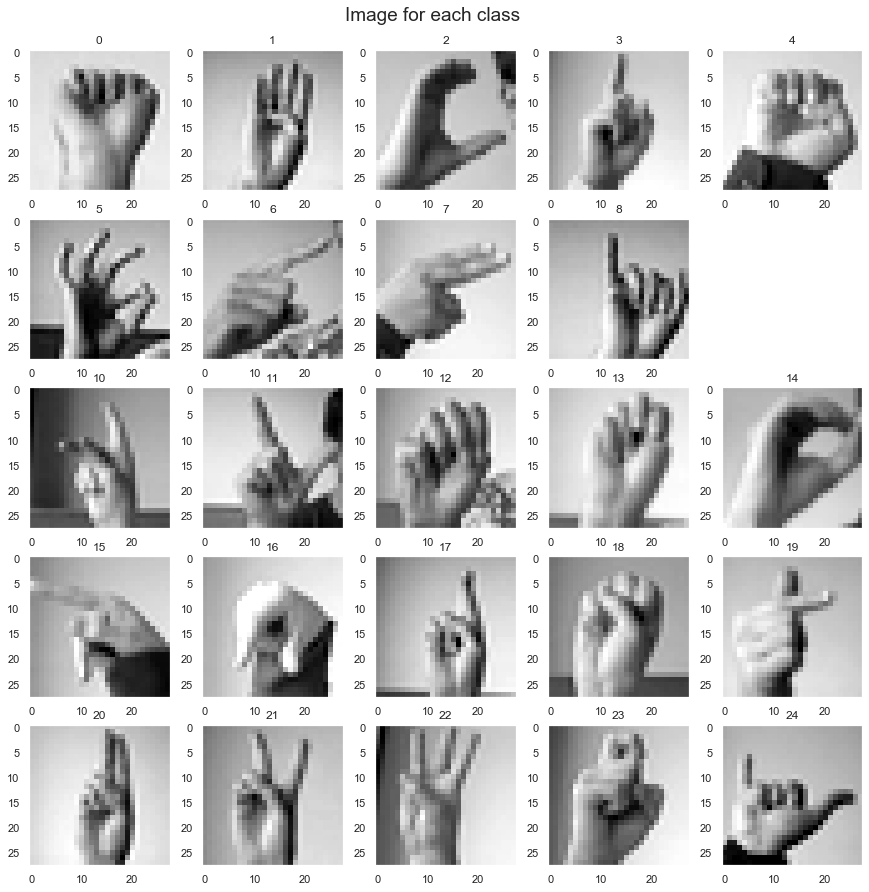

<Figure size 432x288 with 0 Axes>

In [72]:
fig = plt.figure(figsize=(15,15))

for i in val:

    s = i + 1
    plt.subplot(5,5,s)
    
    result = np.where(y_train_full == i)
    plt.imshow(X_train_full[result[0][0],:,:],cmap='gray')
    
    plt.title(i)
    plt.grid(False)
    plt.suptitle("Image for each class",size=19,y=0.92)
    
plt.show()
plt.subplots_adjust(top = 0.91,left=0.1,right= 0.93,hspace = 0.5,wspace = 0.3)

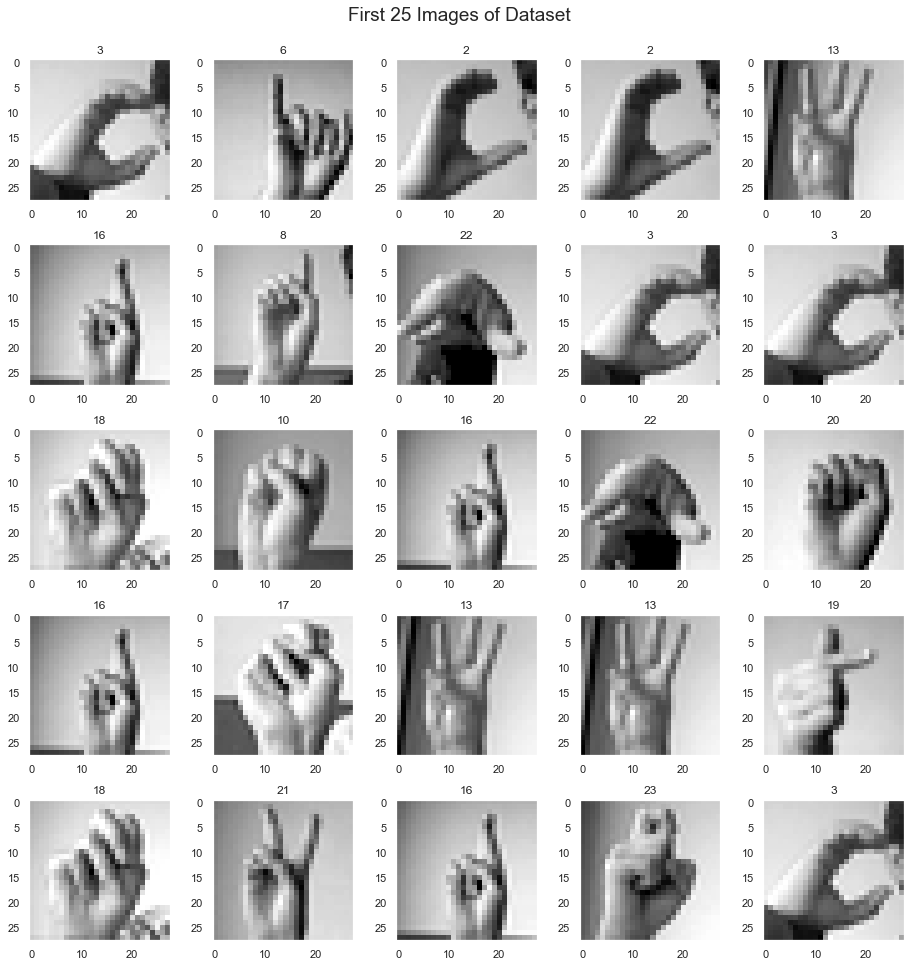

In [73]:
fig = plt.figure(figsize = (13,13),tight_layout=True)

for i,b in enumerate(y_train_full[:25]):
    
    # Enumerate starting at 0, add 1 for subplotting
    i = i + 1
    
    # Create axes object 
    ax = fig.add_subplot(5,5,i)
   
    # Plot  histogram using seaborn
    plt.imshow(X_train_full[b,:,:], cmap='gray')
    plt.title(b)
    plt.grid(False)

plt.suptitle('First 25 Images of Dataset', y=1.03, size=19)
plt.tight_layout()
plt.show()

#### Observations

***
-> Classes D(3), R(17) and U(20) look alike. All of these images have the index finger or two fingers pointing upwards and are difficult to distinguish.

-> Classes A(0), E(4), M(12), N(13) and S(18) are also very similar. All have a closed fist.

-> So i think the classes A, E, D, M, N, R, S and U would be difficult to distinguish.
***

#### Look at the distribution of the labels

In [95]:
y_train_full

array([ 3,  6,  2, ..., 18, 17, 23])

In [96]:
y_test_full

array([ 6,  5, 10, ...,  2,  4,  2])

In [97]:
y_train_uniq = np.unique(y_train_full)
y_train_uniq

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])

In [98]:
y_test_uniq = np.unique(y_test_full)
y_test_uniq

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])

In [99]:
#label 9 and 25 are missing, so we have total 24 labels
#we will have 24 class name only 

In [100]:
print(y_train_full.dtype)
print(y_test_full.dtype)

int64
int64


In [101]:
# check shape of data
print("Training data shape: ",X_train_full.shape)
print("Training data shape: ",y_train_full.shape)
print()
print("Testing data shape: ",X_test_full.shape)
print("Testing data shape: ",y_test_full.shape)

Training data shape:  (27455, 28, 28)
Training data shape:  (27455,)

Testing data shape:  (7172, 28, 28)
Testing data shape:  (7172,)


#### Split the data (test, validation and training) and scale it
- I will only take the first 2500 training images  in order to keep run-times down and to make training more challenging. 
- I will create both the validation and test sets from the testing dataset.  It is unusual to do this, but in this case the training set contains a lot of non-independent, augmented images and it is important that the validation images must be independent. 
- I will take 1000 images each for the validation and test sets.


In [102]:
X_test_full = X_test_full /255.0
X_train_full = X_train_full /255.0

#taking 1000 images for validation numbered from 2000 to 3000 in testing set 
#taking first 2500 images for training
X_valid, X_train = X_test_full[2000:3000:1,:,:],  X_train_full[:2500] 
y_valid_, y_train_ = y_test_full[2000:3000:1],  y_train_full[:2500]

#taking first 1000 images for training
X_test = X_test_full[:1000]
y_test_ = y_test_full[:1000]

#naming the classes from A to Y
class_names = np.array(["A","B","C","D","E","F","G","H","I","J","K","L","M","N","O","P","Q","R","S","T","U","V","W","X","Y"])

#print first 25 class names
print(class_names[y_train_[:25]])

['D' 'G' 'C' 'C' 'N' 'Q' 'I' 'W' 'D' 'D' 'S' 'K' 'Q' 'W' 'U' 'Q' 'R' 'N'
 'N' 'T' 'S' 'V' 'Q' 'X' 'D']


In [103]:
print(X_train.shape)

(2500, 28, 28)


In [104]:
y_train_.shape

(2500,)

In [105]:
X_train = X_train.reshape((-1, 28, 28, 1))
X_valid = X_valid.reshape((-1, 28, 28, 1))
X_test = X_test.reshape((-1, 28, 28, 1))

#### Look at label distribution


In [106]:
print("Data type")

print(X_train.dtype)
print(y_train_.dtype)

print(X_valid.dtype)
print(y_valid_.dtype)

Data type
float64
int64
float64
int64


In [107]:
print("Shape")

#training set
print("X_train: ",X_train.shape)
print("y_train_: ",y_train_.shape)
print()

#validation set
print("X_valid: ", X_valid.shape)
print("y_valid_: ",y_valid_.shape)
print()

#test set
print("X_test: ",X_test.shape)
print("y_test:_ ",y_test_.shape)

Shape
X_train:  (2500, 28, 28, 1)
y_train_:  (2500,)

X_valid:  (1000, 28, 28, 1)
y_valid_:  (1000,)

X_test:  (1000, 28, 28, 1)
y_test:_  (1000,)


In [108]:
from tensorflow.keras.utils import to_categorical

#one hot encoding the labels
y_train = to_categorical(y_train_)
y_test = to_categorical(y_test_)
y_valid = to_categorical(y_valid_)

In [109]:
print("Shape")

print("y_train: ",y_train.shape)
print()
print("y_valid: ",y_valid.shape)
print()
print("y_test: ",y_test.shape)

Shape
y_train:  (2500, 25)

y_valid:  (1000, 25)

y_test:  (1000, 25)


****

## 2. Initialising Deep Learning Networks 


 - I will treat this as a classification problem.
 
 
 - I will build a convolutional neural network (CNN) with the following specifications:
   - All filter (kernel) sizes are 3x3
   - Initial Conv2D layer with 64 filters
   - MaxPooling layer following this
   - Second Conv2D layer with 128 filters
   - Dense output layer after this
  
  
 - The number of epochs is **20** 
 - The batch size is 50
 - I will use the *Adam* optimiser, with its default learning rate
 - I will use the *ELU* activation function for the hidden layers 
 - Training/Validation/Testing set sizes are 2500/1000/1000, as described above

In [110]:
# Some key parameters
n_train = 2500
n_valid = 1000

# the number and size of hidden layers
hiddensizes = [64,128]  

# the activation function to be used in hidden layers
actfn = "elu"  

# Optimiser and learning rate
optimizer = keras.optimizers.Adam   

learningrate = 0.001   # Adam default value

# Set size of batch and number of epochs
batch_size = 50
n_epochs = 20

In [111]:
# CNN model
def model_cnn_factory(hiddensizes, actfn, optimizer, learningrate=0):
    
    model = keras.models.Sequential()
    
    # input layer goes into this 2D convolution
    model.add(keras.layers.Conv2D(filters=hiddensizes[0], kernel_size = 3, strides = 2, activation=actfn,
                                  padding="same", input_shape=[28, 28, 1]))        
    # Pool (downsize)
    model.add(keras.layers.MaxPooling2D(pool_size = (2,2)))          
    
    # 2nd convolution
    model.add(keras.layers.Conv2D(filters=hiddensizes[1], kernel_size=(3,3), strides = 2, padding="same",
                                  activation=actfn))      
    # unravel into a 1D vector  
    model.add(keras.layers.Flatten())                          
    
    #dense layer
    model.add(keras.layers.Dense(25, activation = "softmax"))  
   
    model.compile(loss="categorical_crossentropy", optimizer = optimizer(lr=learningrate), metrics=["accuracy"])   
    return model

In [112]:
def do_all(hiddensizes, actfn, optimizer, learningrate, n_train, n_valid, n_epochs, batch_size):
    
    #CNN model
    model = model_cnn_factory(hiddensizes, actfn, optimizer, learningrate)
    
    #fit the model
    history = model.fit(X_train, y_train, epochs=n_epochs,validation_data =(X_valid, y_valid))
    
    #calcualte val_accuracy 
    max_val_acc = np.max(history.history['val_accuracy'])
    
    #evaluate the model
    testres = model.evaluate(X_test, y_test, verbose=0)
    
    return (max_val_acc, testres[1], history, model)

In [113]:
print("Shape")

#training set
print("X_train: ",X_train.shape)
print("y_train: ",y_train.shape)
print()

#validation set
print("X_valid: ", X_valid.shape)
print("y_valid: ",y_valid.shape)
print()

#test set
print("X_test: ",X_test.shape)
print("y_test: ",y_test.shape)

Shape
X_train:  (2500, 28, 28, 1)
y_train:  (2500, 25)

X_valid:  (1000, 28, 28, 1)
y_valid:  (1000, 25)

X_test:  (1000, 28, 28, 1)
y_test:  (1000, 25)


In [114]:
valacc, testacc, history, model = do_all(hiddensizes, actfn, optimizer, learningrate, n_train, n_valid, n_epochs,batch_size)

seconds = time.time()
print("Seconds since epoch = ", seconds)

Epoch 1/20
79/79 [==============================] - 1s 13ms/step - loss: 2.9968 - accuracy: 0.1432 - val_loss: 2.5549 - val_accuracy: 0.2720
Epoch 2/20
79/79 [==============================] - 1s 11ms/step - loss: 1.7471 - accuracy: 0.4932 - val_loss: 1.4933 - val_accuracy: 0.5420
Epoch 3/20
79/79 [==============================] - 1s 11ms/step - loss: 1.0314 - accuracy: 0.6988 - val_loss: 1.0803 - val_accuracy: 0.6670
Epoch 4/20
79/79 [==============================] - 1s 11ms/step - loss: 0.7454 - accuracy: 0.7960 - val_loss: 0.9613 - val_accuracy: 0.6800
Epoch 5/20
79/79 [==============================] - 1s 12ms/step - loss: 0.5571 - accuracy: 0.8376 - val_loss: 0.8754 - val_accuracy: 0.7180
Epoch 6/20
79/79 [==============================] - 1s 15ms/step - loss: 0.4449 - accuracy: 0.8768 - val_loss: 0.8331 - val_accuracy: 0.7130
Epoch 7/20
79/79 [==============================] - 1s 13ms/step - loss: 0.3650 - accuracy: 0.8932 - val_loss: 0.7364 - val_accuracy: 0.7740
Epoch 8/20
79

In [117]:
#It takes approximately 20 seconds to run this code on my computer.
#So i will continue to use 2500 images for training.

In [118]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 4, 128)         73856     
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 25)                51225     
Total params: 125,721
Trainable params: 125,721
Non-trainable params: 0
_________________________________________________________________


In [119]:
# We can inspect the output class predictions
y_pred = model.predict_classes(X_test)  # use the first t test cases as an example

print(y_pred)   # predicted classes

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
[ 6  5 10  0  3 21 10 14  3  7  8  8 21 12  7  4 22  0  7  7  2  0 21  4
 10 15  2 15  7  1  7  8 13 19 23 21  0  3 18 14 15 23  8 15 14  5 21  4
  7 12 20 22 17  5 16 16 21  4  6 22 10 12 11 22  2 10  1  4 13  4 20  6
 15  4  3 17 15 11  2  2 17  2 12 21 23  7 12 11 18  5  2  1  7 19  8  5
  0  0 19 21  8  4  2 17 16  1 15 14  2  6 12  5  0 24  2  7 13 24 18 24
  4  8  8 12 12  8  6 11  4 15 11 21  2 15 23 23  4 21 22  3 15 13  7 21
 21  6  1  7 10  5  4 23  3 23  5 23  2 10  7  5 14 23  8  4 18 23 13  3
  6  8 13 15  4 16  3 17 18  6 21  1 13 16 24 23  2  7  8 24  1 12 23  3
  0 15  0 15 13  5 11  1  7  6  8 22 22  0 11 23 17  2  3  7 14 13 18  6
  3 15  4

In [120]:
# results (loss and accuracy)
testres1 = model.evaluate(X_valid, y_valid, verbose=0)

print("Validation set")
print('loss, accuracy:', testres1)

Validation set
loss, accuracy: [0.6745094060897827, 0.8199999928474426]


In [121]:
# results (loss and accuracy)
testres = model.evaluate(X_test, y_test, verbose=0)

print("Test set")
print('loss, accuracy:', testres)

Test set
loss, accuracy: [0.6897092461585999, 0.8270000219345093]


In [138]:
#plot accuracy and loss curves
def plot_history(history):
    
    plt.figure(figsize=(8,5),linewidth = 7, edgecolor="whitesmoke")    
    n = len(history.history['accuracy'])
    
    plt.plot(np.arange(0,n),history.history['accuracy'], color='orange',marker=".")
    plt.plot(np.arange(0,n),history.history['loss'],'b',marker=".")
    
    # offset both validation curves
    plt.plot(np.arange(0,n)+0.5,history.history['val_accuracy'],'r',marker=".")  
    plt.plot(np.arange(0,n)+0.5,history.history['val_loss'],'g',marker=".")
    
    plt.legend(['Train Acc','Train Loss','Val Acc','Val Loss'])
    plt.grid(True)
    
    # set vertical limit to 1
    plt.gca().set_ylim(0, 1)
   
    plt.xlabel("Number of Epochs")
    plt.ylabel("Value")
    plt.suptitle("Learning Curve", size=16, y=0.927)
    plt.show() 

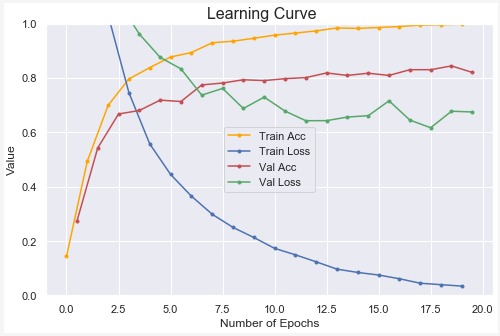

In [139]:
plot_history(history)

##### How you could alleviate problems due to (a) overfitting and (b) underfitting:

- (a) overfitting
  - add more training data if possible
  - reduce the network’s capacity by removing layers or reducing the number of elements in the hidden layers
  - use Dropout layers
  - use regularisation (L1 regularization or L2 regularization)


- (b) underfitting
  - Increase the number of layers in the model
  - Increase the number of neurons in each layer
  - Change what type of layers we’re using and where
  - reduce dropout

***

## 3. Network Optimisation 

The following is the setting for the networks:
 - Batch size of 50
 - Maximum number of epochs of 100, but implement *early stopping*
 -  *Adam* optimiser
 -  *ELU* activation function for all hidden layers 
 -  He Uniform initialization for weights 
 - Training/Validation/Testing set sizes are 2500/1000/1000 as described above (with the validation set derived from the original test dataset) 

I will investigate **both** fully connected and CNN architectures.

#### Approach  to optimisation:

- First i will explore the number of and size of hidden layers. I will see how my model performs for different layers. We know that MLP with just one hidden layer can theoretically model even the mostcomplex functions if it has enough neurons. Though for complex problems, deep networks have a much higher efficiency. My training and testing data sizes are 2500 and 1000 which is not too big, so 2 or three layers can give a good performance.


- Second i will explore the learning rate. The learning rate is one the most important hyperparameter. I will loop over the values 0.0001,0.001,0.01 and 0.1 to get a good performimg model. When plotting the loss as a function of the learning rate, it should drop at first but after sometime, the learning rate will become too large, so the loss will start to increase. Therefore using the Adam optimizer, the learning rate should lie around its default value.


- Then i will use GridSearch to find the best epoch number for the model.I will use values between 20 to 100.Epoch value less than 20 may not be sufficient to train the network properly.Convolutional Neural Networks can be sensitive to the batch size. A disadvantage of using grid search is that it is very time consuming but it's result provide good parameters.


- Lastly i will explore the performance of the CNN network for different number of strides. A big stride in the pooling layer can lead to a high information loss.A stride of 2 or (2,2) is a fair choice.
***

Terminology:
#CNN-> Convolutional Neural Network , DNN-> fully connected Neural Network/ Dense Neural Network

### I. Exploring layers:

In [125]:
#  Convolutional Neural Network model
def model_cnn(hiddensizes, actfn, optimizer, learningrate = 0):
    
    model = keras.models.Sequential()
    
    #input layer goes into this 2D convolution
    model.add(keras.layers.Conv2D(filters=hiddensizes[0], kernel_size=(3,3), strides=(2,2), activation=actfn, padding="same",kernel_initializer="he_uniform", 
                                  input_shape=[28, 28, 1]))
    # Pool (downsize)
    model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))          
    
    for n in hiddensizes[1:-1]:
        # 2nd Conv
        model.add(keras.layers.Conv2D(filters=n, kernel_size=(3,3), strides= (2,2), padding="same", activation=actfn,kernel_initializer="he_uniform"))  
        # Pool (downsize)
        model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))          
    
    # 3rd Conv
    model.add(keras.layers.Conv2D(filters=hiddensizes[-1], kernel_size=(3,3), strides= (2,2), padding="same", activation=actfn,kernel_initializer="he_uniform"))  
    
    # unravel into a 1D vector
    model.add(keras.layers.Flatten()) 
    
    #dense layer
    model.add(keras.layers.Dense(25, activation = "softmax"))  
    
    #compile the model
    model.compile(loss="categorical_crossentropy", optimizer=optimizer(lr=learningrate), metrics=["accuracy"]) 
    # use "categorical_crossentropy" loss as labels are one hot encoded
    
    return model

In [126]:
#  Dense Neural Network model
def model_dnn(hiddensizes, actfn, optimizer, learningrate):
    
    model = keras.models.Sequential()
    
    #size down
    model.add(keras.layers.Flatten(input_shape = [28 , 28]))    
    
    for n in hiddensizes:
        # add 2D convolution layers
        model.add(keras.layers.Dense(n, activation = actfn,kernel_initializer="he_uniform"))
    
    #dense layer
    model.add(keras.layers.Dense(25, activation = "softmax"))   # always have 10 classes
    
    #compile the model
    model.compile(loss="categorical_crossentropy", optimizer=optimizer(lr=learningrate), metrics=["accuracy"])
    return model

In [127]:
def do_all2(model,hiddensizes, actfn, optimizer, learningrate, n_train, n_valid, n_epochs, batch_size, further_callbacks=[]):
    
    #call the cnn or dnn model method
    mod = model(hiddensizes, actfn, optimizer, learningrate)
    
    #fit the model
    history = mod.fit(X_train[:n_train,:,:,:], y_train[:n_train], epochs=n_epochs, callbacks = [early_stopping_cb] + further_callbacks,
                        validation_data=(X_valid[:n_valid,:,:,:], y_valid[:n_valid]))
    #calculate accuracy
    max_val_acc = np.max(history.history['val_accuracy'])
    #evaluate the model
    testres = mod.evaluate(X_test, y_test, verbose=0)
    
    return (max_val_acc, testres[1], history, mod)

In [130]:
#  Early stopping callback
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience = 10, restore_best_weights=True)

### #1st combination of layers : 32,64,128

#### CNN

Epoch 1/20
79/79 [==============================] - 1s 7ms/step - loss: 3.0608 - accuracy: 0.1192 - val_loss: 2.8628 - val_accuracy: 0.1430
Epoch 2/20
79/79 [==============================] - 0s 6ms/step - loss: 2.3864 - accuracy: 0.3588 - val_loss: 2.1098 - val_accuracy: 0.4010
Epoch 3/20
79/79 [==============================] - 0s 5ms/step - loss: 1.6675 - accuracy: 0.5456 - val_loss: 1.5377 - val_accuracy: 0.5880
Epoch 4/20
79/79 [==============================] - 0s 6ms/step - loss: 1.2380 - accuracy: 0.6520 - val_loss: 1.2926 - val_accuracy: 0.6230
Epoch 5/20
79/79 [==============================] - 0s 5ms/step - loss: 0.9565 - accuracy: 0.7384 - val_loss: 1.1889 - val_accuracy: 0.6180
Epoch 6/20
79/79 [==============================] - 0s 5ms/step - loss: 0.7831 - accuracy: 0.7940 - val_loss: 1.0448 - val_accuracy: 0.6680
Epoch 7/20
79/79 [==============================] - 0s 5ms/step - loss: 0.6624 - accuracy: 0.8160 - val_loss: 0.9538 - val_accuracy: 0.6860
Epoch 8/20
79/79 [==

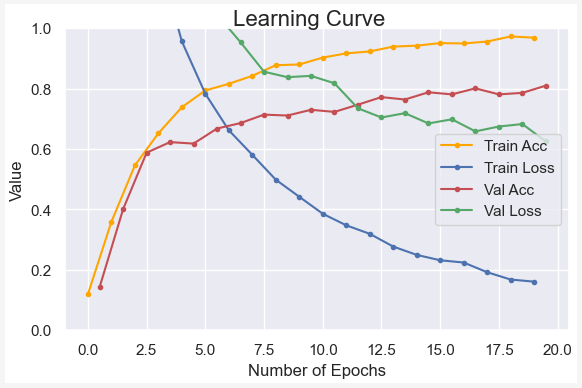

Epoch 1/20
79/79 [==============================] - 1s 8ms/step - loss: 2.9234 - accuracy: 0.1840 - val_loss: 2.5261 - val_accuracy: 0.2900
Epoch 2/20
79/79 [==============================] - 0s 6ms/step - loss: 1.8920 - accuracy: 0.5020 - val_loss: 1.6654 - val_accuracy: 0.5140
Epoch 3/20
79/79 [==============================] - 0s 6ms/step - loss: 1.1871 - accuracy: 0.6740 - val_loss: 1.1901 - val_accuracy: 0.6620
Epoch 4/20
79/79 [==============================] - 0s 6ms/step - loss: 0.8571 - accuracy: 0.7660 - val_loss: 1.0319 - val_accuracy: 0.6760
Epoch 5/20
79/79 [==============================] - 0s 6ms/step - loss: 0.6493 - accuracy: 0.8368 - val_loss: 0.9541 - val_accuracy: 0.6870
Epoch 6/20
79/79 [==============================] - 0s 6ms/step - loss: 0.5328 - accuracy: 0.8608 - val_loss: 0.8474 - val_accuracy: 0.7050
Epoch 7/20
79/79 [==============================] - 0s 6ms/step - loss: 0.4384 - accuracy: 0.8844 - val_loss: 0.7908 - val_accuracy: 0.7260
Epoch 8/20
79/79 [==

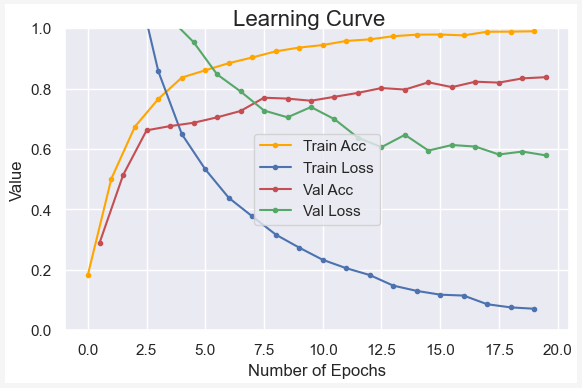

Epoch 1/20
79/79 [==============================] - 1s 8ms/step - loss: 3.0696 - accuracy: 0.1284 - val_loss: 2.8807 - val_accuracy: 0.1590
Epoch 2/20
79/79 [==============================] - 0s 6ms/step - loss: 2.2395 - accuracy: 0.3512 - val_loss: 2.0022 - val_accuracy: 0.3780
Epoch 3/20
79/79 [==============================] - 1s 8ms/step - loss: 1.5119 - accuracy: 0.5544 - val_loss: 1.5108 - val_accuracy: 0.5550
Epoch 4/20
79/79 [==============================] - 0s 6ms/step - loss: 1.0866 - accuracy: 0.6904 - val_loss: 1.4037 - val_accuracy: 0.5520
Epoch 5/20
79/79 [==============================] - 1s 7ms/step - loss: 0.8197 - accuracy: 0.7656 - val_loss: 1.0694 - val_accuracy: 0.6490
Epoch 6/20
79/79 [==============================] - 1s 6ms/step - loss: 0.6136 - accuracy: 0.8248 - val_loss: 1.0669 - val_accuracy: 0.6260
Epoch 7/20
79/79 [==============================] - 1s 7ms/step - loss: 0.4898 - accuracy: 0.8620 - val_loss: 0.8561 - val_accuracy: 0.6890
Epoch 8/20
79/79 [==

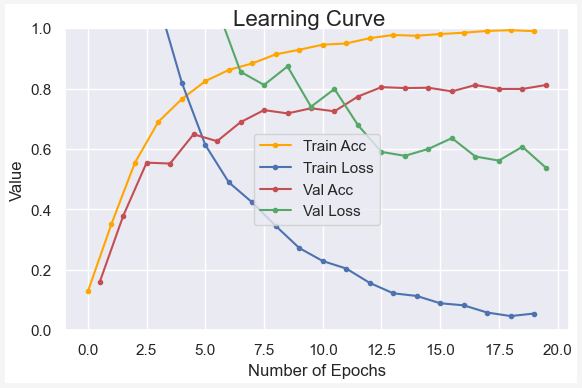

[[1, 0.8100000023841858, 0.8050000071525574], [2, 0.8379999995231628, 0.8339999914169312], [3, 0.8119999766349792, 0.8259999752044678]]


In [40]:
hiddensizes1 = [32,64,128]

res=[]

for n in [1,2,3]:
    valacc1, testacc1, history_cnn_layer1, discard = do_all2(model_cnn,hiddensizes1[:n], actfn, optimizer, learningrate, n_train, n_valid, n_epochs, batch_size)
    plot_history(history_cnn_layer1)
    res += [[n,valacc1,testacc1]]
print(res)

In [41]:
#best accuarcy on validation and testing set : 0.8379999995231628, 0.8339999914169312 (2 layers)

#### DNN

Epoch 1/20
79/79 [==============================] - 0s 3ms/step - loss: 3.1307 - accuracy: 0.0980 - val_loss: 2.9641 - val_accuracy: 0.0890
Epoch 2/20
79/79 [==============================] - 0s 2ms/step - loss: 2.7469 - accuracy: 0.2192 - val_loss: 2.6535 - val_accuracy: 0.2380
Epoch 3/20
79/79 [==============================] - 0s 2ms/step - loss: 2.4043 - accuracy: 0.3204 - val_loss: 2.3218 - val_accuracy: 0.3430
Epoch 4/20
79/79 [==============================] - 0s 2ms/step - loss: 2.1479 - accuracy: 0.3868 - val_loss: 2.2037 - val_accuracy: 0.3050
Epoch 5/20
79/79 [==============================] - 0s 2ms/step - loss: 1.9267 - accuracy: 0.4416 - val_loss: 1.9754 - val_accuracy: 0.4150
Epoch 6/20
79/79 [==============================] - 0s 5ms/step - loss: 1.7579 - accuracy: 0.4760 - val_loss: 1.9276 - val_accuracy: 0.4440
Epoch 7/20
79/79 [==============================] - 0s 2ms/step - loss: 1.6174 - accuracy: 0.5304 - val_loss: 1.7930 - val_accuracy: 0.4590
Epoch 8/20
79/79 [==

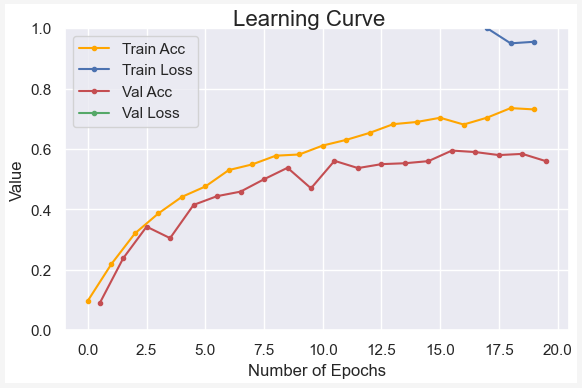

Epoch 1/20
79/79 [==============================] - 0s 4ms/step - loss: 3.0961 - accuracy: 0.0892 - val_loss: 2.9602 - val_accuracy: 0.1250
Epoch 2/20
79/79 [==============================] - 0s 2ms/step - loss: 2.6080 - accuracy: 0.2200 - val_loss: 2.5569 - val_accuracy: 0.1930
Epoch 3/20
79/79 [==============================] - 0s 2ms/step - loss: 2.1778 - accuracy: 0.3368 - val_loss: 2.1518 - val_accuracy: 0.3070
Epoch 4/20
79/79 [==============================] - 0s 2ms/step - loss: 1.8480 - accuracy: 0.4352 - val_loss: 1.9852 - val_accuracy: 0.3830
Epoch 5/20
79/79 [==============================] - 0s 2ms/step - loss: 1.6649 - accuracy: 0.4764 - val_loss: 1.9217 - val_accuracy: 0.3440
Epoch 6/20
79/79 [==============================] - 0s 2ms/step - loss: 1.4927 - accuracy: 0.5336 - val_loss: 1.7501 - val_accuracy: 0.4610
Epoch 7/20
79/79 [==============================] - 0s 2ms/step - loss: 1.3843 - accuracy: 0.5588 - val_loss: 1.6099 - val_accuracy: 0.4840
Epoch 8/20
79/79 [==

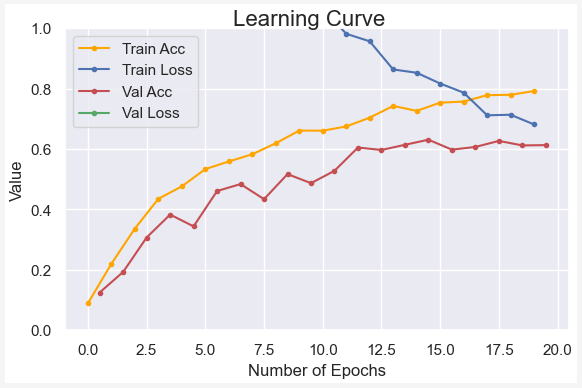

Epoch 1/20
79/79 [==============================] - 0s 4ms/step - loss: 3.0033 - accuracy: 0.1304 - val_loss: 2.7229 - val_accuracy: 0.1910
Epoch 2/20
79/79 [==============================] - 0s 2ms/step - loss: 2.3188 - accuracy: 0.2860 - val_loss: 2.1581 - val_accuracy: 0.3230
Epoch 3/20
79/79 [==============================] - 0s 2ms/step - loss: 1.8679 - accuracy: 0.4096 - val_loss: 1.9034 - val_accuracy: 0.4260
Epoch 4/20
79/79 [==============================] - 0s 2ms/step - loss: 1.6443 - accuracy: 0.4724 - val_loss: 1.7382 - val_accuracy: 0.4290
Epoch 5/20
79/79 [==============================] - 0s 2ms/step - loss: 1.4871 - accuracy: 0.5172 - val_loss: 1.6281 - val_accuracy: 0.4520
Epoch 6/20
79/79 [==============================] - 0s 2ms/step - loss: 1.3343 - accuracy: 0.5664 - val_loss: 1.7244 - val_accuracy: 0.4440
Epoch 7/20
79/79 [==============================] - 0s 2ms/step - loss: 1.1909 - accuracy: 0.6196 - val_loss: 1.4061 - val_accuracy: 0.5520
Epoch 8/20
79/79 [==

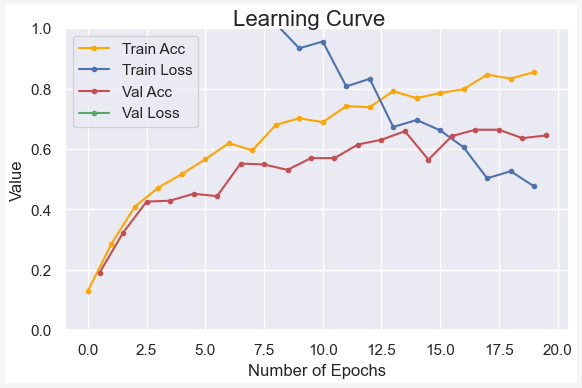

[[1, 0.5950000286102295, 0.5329999923706055], [2, 0.6309999823570251, 0.609000027179718], [3, 0.6639999747276306, 0.6119999885559082]]


In [42]:
res=[]

for n in [1,2,3]:
    valacc1_, testacc1_, history_dnn_layer1, discard = do_all2(model_dnn,hiddensizes1[:n], actfn, optimizer, learningrate, n_train, n_valid, n_epochs, batch_size)
    plot_history(history_dnn_layer1)
    res += [[n,valacc1_,testacc1_]]
print(res)

In [43]:
#best accuarcy on validation and testing set : 0.6639999747276306, 0.6119999885559082 (3 layers)

### #2nd combination of layers: 64,128,256

#### CNN

Epoch 1/20
79/79 [==============================] - 1s 11ms/step - loss: 2.9885 - accuracy: 0.1616 - val_loss: 2.5750 - val_accuracy: 0.2170
Epoch 2/20
79/79 [==============================] - 1s 10ms/step - loss: 1.9539 - accuracy: 0.4536 - val_loss: 1.6799 - val_accuracy: 0.4780
Epoch 3/20
79/79 [==============================] - 1s 10ms/step - loss: 1.2414 - accuracy: 0.6524 - val_loss: 1.2380 - val_accuracy: 0.6670
Epoch 4/20
79/79 [==============================] - 1s 10ms/step - loss: 0.9101 - accuracy: 0.7388 - val_loss: 1.1300 - val_accuracy: 0.6290
Epoch 5/20
79/79 [==============================] - 1s 9ms/step - loss: 0.6878 - accuracy: 0.8124 - val_loss: 0.9118 - val_accuracy: 0.7100
Epoch 6/20
79/79 [==============================] - 1s 10ms/step - loss: 0.5519 - accuracy: 0.8504 - val_loss: 0.9012 - val_accuracy: 0.7220
Epoch 7/20
79/79 [==============================] - 1s 9ms/step - loss: 0.4481 - accuracy: 0.8780 - val_loss: 0.7935 - val_accuracy: 0.7300
Epoch 8/20
79/7

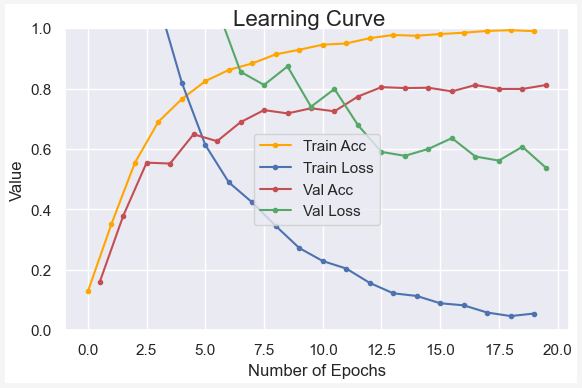

Epoch 1/20
79/79 [==============================] - 1s 12ms/step - loss: 2.7836 - accuracy: 0.2408 - val_loss: 2.1437 - val_accuracy: 0.3690
Epoch 2/20
79/79 [==============================] - 1s 11ms/step - loss: 1.4715 - accuracy: 0.5816 - val_loss: 1.4120 - val_accuracy: 0.5330
Epoch 3/20
79/79 [==============================] - 1s 10ms/step - loss: 0.8681 - accuracy: 0.7516 - val_loss: 1.0086 - val_accuracy: 0.6990
Epoch 4/20
79/79 [==============================] - 1s 11ms/step - loss: 0.6161 - accuracy: 0.8364 - val_loss: 0.9509 - val_accuracy: 0.6910
Epoch 5/20
79/79 [==============================] - 1s 11ms/step - loss: 0.4699 - accuracy: 0.8820 - val_loss: 0.7541 - val_accuracy: 0.7650
Epoch 6/20
79/79 [==============================] - 1s 11ms/step - loss: 0.3695 - accuracy: 0.8988 - val_loss: 0.7706 - val_accuracy: 0.7510
Epoch 7/20
79/79 [==============================] - 1s 10ms/step - loss: 0.2949 - accuracy: 0.9308 - val_loss: 0.6778 - val_accuracy: 0.7830
Epoch 8/20
79

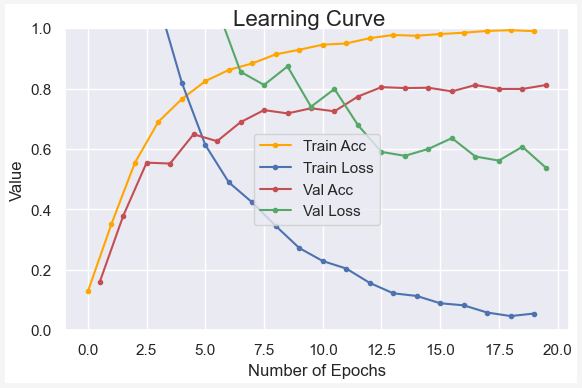

Epoch 1/20
79/79 [==============================] - 2s 21ms/step - loss: 2.7663 - accuracy: 0.2224 - val_loss: 2.2697 - val_accuracy: 0.2780
Epoch 2/20
79/79 [==============================] - 1s 15ms/step - loss: 1.4689 - accuracy: 0.5624 - val_loss: 1.3548 - val_accuracy: 0.5680
Epoch 3/20
79/79 [==============================] - 1s 15ms/step - loss: 0.8450 - accuracy: 0.7408 - val_loss: 0.9004 - val_accuracy: 0.6980
Epoch 4/20
79/79 [==============================] - 1s 15ms/step - loss: 0.5495 - accuracy: 0.8352 - val_loss: 0.9480 - val_accuracy: 0.6900
Epoch 5/20
79/79 [==============================] - 1s 15ms/step - loss: 0.3991 - accuracy: 0.8928 - val_loss: 0.7103 - val_accuracy: 0.7750
Epoch 6/20
79/79 [==============================] - 1s 15ms/step - loss: 0.2694 - accuracy: 0.9276 - val_loss: 0.6527 - val_accuracy: 0.7690
Epoch 7/20
79/79 [==============================] - 1s 15ms/step - loss: 0.2005 - accuracy: 0.9516 - val_loss: 0.6284 - val_accuracy: 0.8050
Epoch 8/20
79

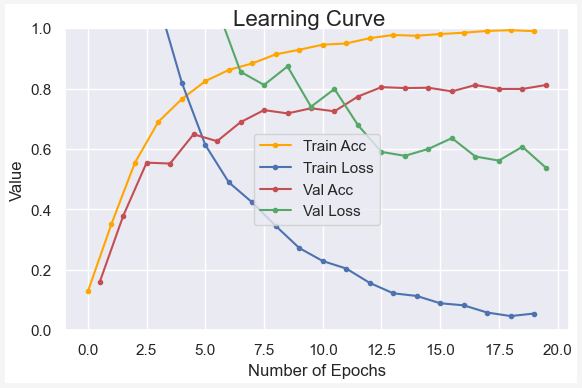

[[1, 0.8349999785423279, 0.8270000219345093], [2, 0.8550000190734863, 0.8309999704360962], [3, 0.8820000290870667, 0.859000027179718]]


In [44]:
hiddensizes2 = [64,128,256]

res=[]

for n in [1,2,3]:
    valacc2, testacc2, history_cnn_layer2, discard = do_all2(model_cnn,hiddensizes2[:n], actfn, optimizer, learningrate, n_train, n_valid, n_epochs, batch_size)
    plot_history(history_cnn_layer1)
    res += [[n,valacc2,testacc2]]
print(res)

In [45]:
#best accuarcy on validation and testing set : 0.8820000290870667, 0.859000027179718 (3 layers)

#### DNN

Epoch 1/20
79/79 [==============================] - 0s 3ms/step - loss: 3.1133 - accuracy: 0.1092 - val_loss: 3.0078 - val_accuracy: 0.0650
Epoch 2/20
79/79 [==============================] - 0s 2ms/step - loss: 2.6742 - accuracy: 0.2268 - val_loss: 2.5888 - val_accuracy: 0.2360
Epoch 3/20
79/79 [==============================] - 0s 2ms/step - loss: 2.2807 - accuracy: 0.3360 - val_loss: 2.2216 - val_accuracy: 0.3220
Epoch 4/20
79/79 [==============================] - 0s 2ms/step - loss: 2.0102 - accuracy: 0.4076 - val_loss: 2.1157 - val_accuracy: 0.3680
Epoch 5/20
79/79 [==============================] - 0s 2ms/step - loss: 1.8043 - accuracy: 0.4660 - val_loss: 2.0243 - val_accuracy: 0.3660
Epoch 6/20
79/79 [==============================] - 0s 2ms/step - loss: 1.6248 - accuracy: 0.5332 - val_loss: 1.8157 - val_accuracy: 0.4240
Epoch 7/20
79/79 [==============================] - 0s 2ms/step - loss: 1.5028 - accuracy: 0.5532 - val_loss: 1.7120 - val_accuracy: 0.4930
Epoch 8/20
79/79 [==

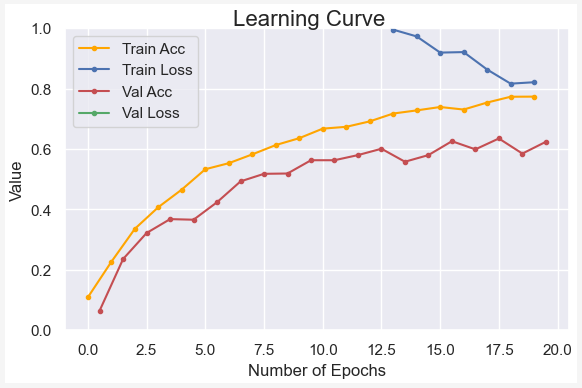

Epoch 1/20
79/79 [==============================] - 0s 4ms/step - loss: 3.1140 - accuracy: 0.1088 - val_loss: 2.9091 - val_accuracy: 0.1290
Epoch 2/20
79/79 [==============================] - 0s 2ms/step - loss: 2.4857 - accuracy: 0.2816 - val_loss: 2.2953 - val_accuracy: 0.3080
Epoch 3/20
79/79 [==============================] - 0s 2ms/step - loss: 1.9866 - accuracy: 0.3964 - val_loss: 1.9444 - val_accuracy: 0.3730
Epoch 4/20
79/79 [==============================] - 0s 2ms/step - loss: 1.6751 - accuracy: 0.4792 - val_loss: 1.9407 - val_accuracy: 0.3990
Epoch 5/20
79/79 [==============================] - 0s 2ms/step - loss: 1.5049 - accuracy: 0.5308 - val_loss: 1.6312 - val_accuracy: 0.4630
Epoch 6/20
79/79 [==============================] - 0s 2ms/step - loss: 1.3068 - accuracy: 0.5904 - val_loss: 1.6753 - val_accuracy: 0.4710
Epoch 7/20
79/79 [==============================] - 0s 2ms/step - loss: 1.2108 - accuracy: 0.6240 - val_loss: 1.4137 - val_accuracy: 0.5250
Epoch 8/20
79/79 [==

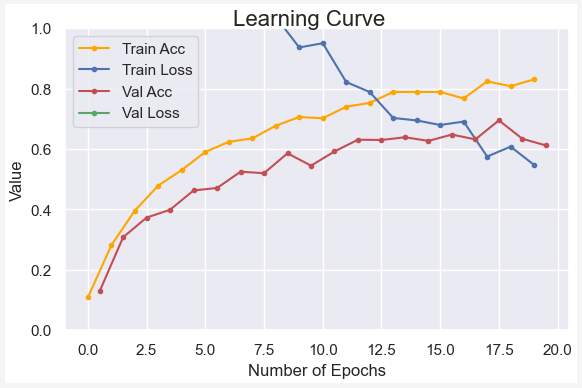

Epoch 1/20
79/79 [==============================] - 0s 4ms/step - loss: 2.9414 - accuracy: 0.1652 - val_loss: 2.6732 - val_accuracy: 0.1290
Epoch 2/20
79/79 [==============================] - 0s 3ms/step - loss: 2.1589 - accuracy: 0.3208 - val_loss: 1.9397 - val_accuracy: 0.3800
Epoch 3/20
79/79 [==============================] - 0s 3ms/step - loss: 1.7002 - accuracy: 0.4444 - val_loss: 1.7264 - val_accuracy: 0.4480
Epoch 4/20
79/79 [==============================] - 0s 3ms/step - loss: 1.4945 - accuracy: 0.5208 - val_loss: 1.8888 - val_accuracy: 0.3930
Epoch 5/20
79/79 [==============================] - 0s 3ms/step - loss: 1.3281 - accuracy: 0.5620 - val_loss: 1.9316 - val_accuracy: 0.4210
Epoch 6/20
79/79 [==============================] - 0s 3ms/step - loss: 1.1959 - accuracy: 0.5968 - val_loss: 1.5358 - val_accuracy: 0.4950
Epoch 7/20
79/79 [==============================] - 0s 3ms/step - loss: 1.0169 - accuracy: 0.6736 - val_loss: 1.3128 - val_accuracy: 0.5770
Epoch 8/20
79/79 [==

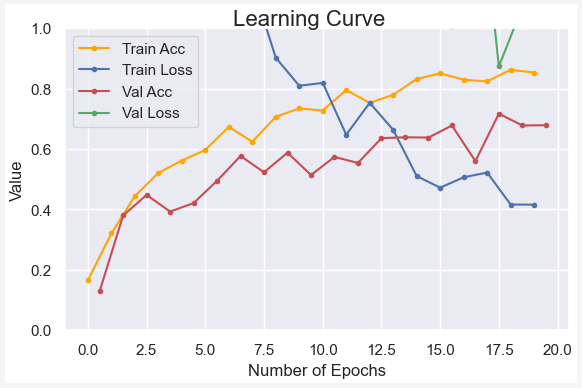

[[1, 0.6349999904632568, 0.6010000109672546], [2, 0.6949999928474426, 0.5799999833106995], [3, 0.7170000076293945, 0.6510000228881836]]


In [46]:
res=[]

for n in [1,2,3]:
    valacc2_, testacc2_, history_dnn_layer2, discard = do_all2(model_dnn,hiddensizes2[:n], actfn, optimizer, learningrate, n_train, n_valid, n_epochs, batch_size)
    plot_history(history_dnn_layer2)
    res += [[n,valacc2_,testacc2_]]
print(res)

In [47]:
#best accuarcy on validation and testing set : 0.7170000076293945, 0.6510000228881836 (3 layers)

### #3nd combination of layers:  32,128,256

#### CNN

Epoch 1/20
79/79 [==============================] - 1s 7ms/step - loss: 3.0090 - accuracy: 0.1388 - val_loss: 2.7281 - val_accuracy: 0.1620
Epoch 2/20
79/79 [==============================] - 0s 5ms/step - loss: 2.2158 - accuracy: 0.4104 - val_loss: 1.9212 - val_accuracy: 0.4380
Epoch 3/20
79/79 [==============================] - 0s 5ms/step - loss: 1.4992 - accuracy: 0.5936 - val_loss: 1.4008 - val_accuracy: 0.5880
Epoch 4/20
79/79 [==============================] - 0s 5ms/step - loss: 1.1169 - accuracy: 0.6856 - val_loss: 1.2297 - val_accuracy: 0.6100
Epoch 5/20
79/79 [==============================] - 0s 6ms/step - loss: 0.8715 - accuracy: 0.7572 - val_loss: 1.1353 - val_accuracy: 0.6100
Epoch 6/20
79/79 [==============================] - 0s 5ms/step - loss: 0.7355 - accuracy: 0.7960 - val_loss: 1.0206 - val_accuracy: 0.6580
Epoch 7/20
79/79 [==============================] - 0s 6ms/step - loss: 0.6275 - accuracy: 0.8272 - val_loss: 0.9490 - val_accuracy: 0.6600
Epoch 8/20
79/79 [==

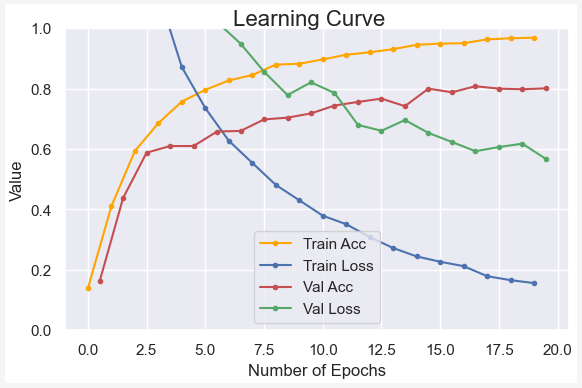

Epoch 1/20
79/79 [==============================] - 1s 8ms/step - loss: 2.8120 - accuracy: 0.2356 - val_loss: 2.2997 - val_accuracy: 0.3350
Epoch 2/20
79/79 [==============================] - 1s 7ms/step - loss: 1.5975 - accuracy: 0.5640 - val_loss: 1.4452 - val_accuracy: 0.5470
Epoch 3/20
79/79 [==============================] - 0s 6ms/step - loss: 0.9704 - accuracy: 0.7364 - val_loss: 1.0421 - val_accuracy: 0.6970
Epoch 4/20
79/79 [==============================] - 1s 7ms/step - loss: 0.6847 - accuracy: 0.8196 - val_loss: 0.9160 - val_accuracy: 0.7190
Epoch 5/20
79/79 [==============================] - 1s 7ms/step - loss: 0.5072 - accuracy: 0.8764 - val_loss: 0.7984 - val_accuracy: 0.7350
Epoch 6/20
79/79 [==============================] - 1s 6ms/step - loss: 0.4042 - accuracy: 0.8964 - val_loss: 0.7560 - val_accuracy: 0.7640
Epoch 7/20
79/79 [==============================] - 1s 7ms/step - loss: 0.3223 - accuracy: 0.9268 - val_loss: 0.6874 - val_accuracy: 0.8070
Epoch 8/20
79/79 [==

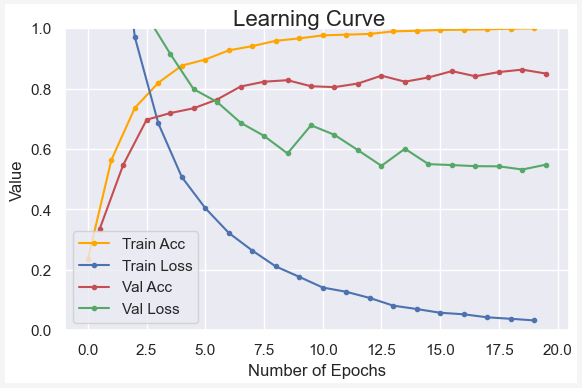

Epoch 1/20
79/79 [==============================] - 1s 12ms/step - loss: 2.9003 - accuracy: 0.2072 - val_loss: 2.2777 - val_accuracy: 0.2860
Epoch 2/20
79/79 [==============================] - 1s 10ms/step - loss: 1.5960 - accuracy: 0.5236 - val_loss: 1.4119 - val_accuracy: 0.5320
Epoch 3/20
79/79 [==============================] - 1s 10ms/step - loss: 0.9005 - accuracy: 0.7364 - val_loss: 0.9763 - val_accuracy: 0.7160
Epoch 4/20
79/79 [==============================] - 1s 10ms/step - loss: 0.6115 - accuracy: 0.8216 - val_loss: 1.1354 - val_accuracy: 0.6080
Epoch 5/20
79/79 [==============================] - 1s 10ms/step - loss: 0.4527 - accuracy: 0.8764 - val_loss: 0.7296 - val_accuracy: 0.7420
Epoch 6/20
79/79 [==============================] - 1s 10ms/step - loss: 0.3165 - accuracy: 0.9188 - val_loss: 0.7816 - val_accuracy: 0.7460
Epoch 7/20
79/79 [==============================] - 1s 10ms/step - loss: 0.2281 - accuracy: 0.9476 - val_loss: 0.6050 - val_accuracy: 0.8050
Epoch 8/20
79

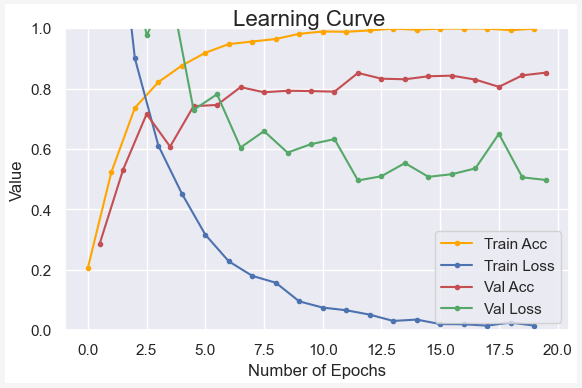

[[1, 0.8080000281333923, 0.7910000085830688], [2, 0.8629999756813049, 0.8460000157356262], [3, 0.8529999852180481, 0.8370000123977661]]


In [48]:
hiddensizes3 = [32,128,256]

res=[]
for n in [1,2,3]:
    valacc3, testacc3, history_cnn_layer3, discard = do_all2(model_cnn,hiddensizes3[:n], actfn, optimizer, learningrate, n_train, n_valid, n_epochs, batch_size)
    plot_history(history_cnn_layer3)
    res += [[n,valacc3,testacc3]]
print(res)

In [49]:
#best accuarcy on validation and testing set : 0.8529999852180481, 0.8370000123977661 (3 layers)

#### DNN

Epoch 1/20
79/79 [==============================] - 0s 3ms/step - loss: 3.1162 - accuracy: 0.1000 - val_loss: 2.9730 - val_accuracy: 0.1180
Epoch 2/20
79/79 [==============================] - 0s 2ms/step - loss: 2.7612 - accuracy: 0.2164 - val_loss: 2.6691 - val_accuracy: 0.2260
Epoch 3/20
79/79 [==============================] - 0s 2ms/step - loss: 2.4203 - accuracy: 0.3228 - val_loss: 2.3409 - val_accuracy: 0.3150
Epoch 4/20
79/79 [==============================] - 0s 2ms/step - loss: 2.1635 - accuracy: 0.3852 - val_loss: 2.1560 - val_accuracy: 0.3260
Epoch 5/20
79/79 [==============================] - 0s 2ms/step - loss: 1.9216 - accuracy: 0.4700 - val_loss: 2.0025 - val_accuracy: 0.3750
Epoch 6/20
79/79 [==============================] - 0s 2ms/step - loss: 1.7586 - accuracy: 0.4952 - val_loss: 1.9604 - val_accuracy: 0.3670
Epoch 7/20
79/79 [==============================] - 0s 2ms/step - loss: 1.6534 - accuracy: 0.5272 - val_loss: 1.8002 - val_accuracy: 0.4380
Epoch 8/20
79/79 [==

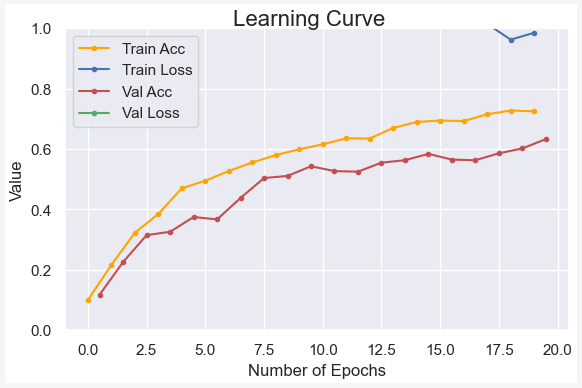

Epoch 1/20
79/79 [==============================] - 0s 3ms/step - loss: 3.1191 - accuracy: 0.0964 - val_loss: 2.9345 - val_accuracy: 0.1630
Epoch 2/20
79/79 [==============================] - 0s 2ms/step - loss: 2.5278 - accuracy: 0.2468 - val_loss: 2.3562 - val_accuracy: 0.2980
Epoch 3/20
79/79 [==============================] - 0s 2ms/step - loss: 2.0612 - accuracy: 0.3672 - val_loss: 2.0240 - val_accuracy: 0.3620
Epoch 4/20
79/79 [==============================] - 0s 2ms/step - loss: 1.7840 - accuracy: 0.4412 - val_loss: 2.0145 - val_accuracy: 0.3640
Epoch 5/20
79/79 [==============================] - 0s 2ms/step - loss: 1.5919 - accuracy: 0.4964 - val_loss: 1.8269 - val_accuracy: 0.4090
Epoch 6/20
79/79 [==============================] - 0s 2ms/step - loss: 1.4205 - accuracy: 0.5572 - val_loss: 1.6724 - val_accuracy: 0.4790
Epoch 7/20
79/79 [==============================] - 0s 2ms/step - loss: 1.3184 - accuracy: 0.5768 - val_loss: 1.6312 - val_accuracy: 0.4950
Epoch 8/20
79/79 [==

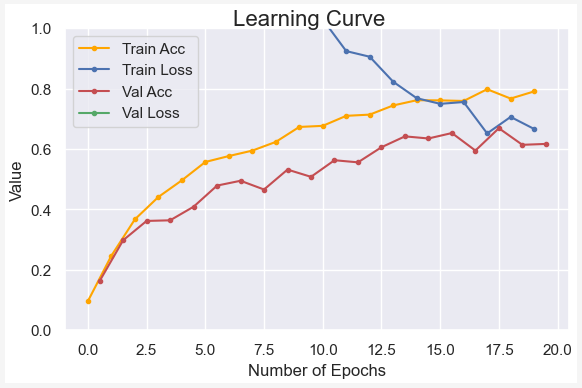

Epoch 1/20
79/79 [==============================] - 0s 4ms/step - loss: 2.9767 - accuracy: 0.1424 - val_loss: 2.5584 - val_accuracy: 0.2000
Epoch 2/20
79/79 [==============================] - 0s 3ms/step - loss: 2.1424 - accuracy: 0.3256 - val_loss: 2.0212 - val_accuracy: 0.3820
Epoch 3/20
79/79 [==============================] - 0s 3ms/step - loss: 1.7223 - accuracy: 0.4348 - val_loss: 1.9287 - val_accuracy: 0.4110
Epoch 4/20
79/79 [==============================] - 0s 2ms/step - loss: 1.5325 - accuracy: 0.4992 - val_loss: 1.6627 - val_accuracy: 0.4460
Epoch 5/20
79/79 [==============================] - 0s 3ms/step - loss: 1.3526 - accuracy: 0.5620 - val_loss: 1.7086 - val_accuracy: 0.4610
Epoch 6/20
79/79 [==============================] - 0s 2ms/step - loss: 1.2625 - accuracy: 0.5772 - val_loss: 1.4951 - val_accuracy: 0.5040
Epoch 7/20
79/79 [==============================] - 0s 3ms/step - loss: 1.0701 - accuracy: 0.6448 - val_loss: 1.3256 - val_accuracy: 0.5630
Epoch 8/20
79/79 [==

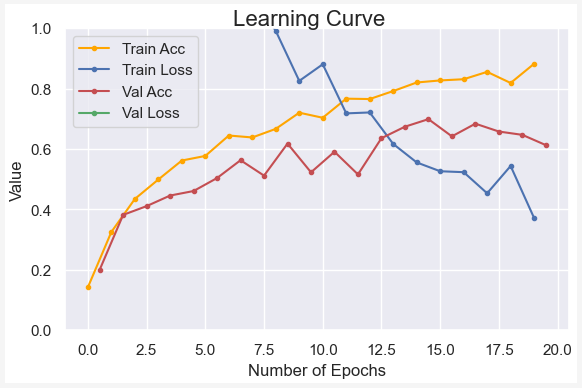

[[1, 0.6330000162124634, 0.6060000061988831], [2, 0.6690000295639038, 0.593999981880188], [3, 0.6990000009536743, 0.5879999995231628]]


In [50]:
hiddensizes3 = [32,128,256]

res=[]
for n in [1,2,3]:
    valacc3_, testacc3_, history_dnn_layer3, discard = do_all2(model_dnn,hiddensizes3[:n], actfn, optimizer, learningrate, n_train, n_valid, n_epochs, batch_size)
    plot_history(history_dnn_layer3)
    res += [[n,valacc3_,testacc3_]]
print(res)

In [51]:
#best accuarcy on validation and testing set : 0.6990000009536743, 0.5879999995231628 (3 layers)

#Observation: 
#### We see the highest accuracy of approximately 88.2% and 85.9%  ( validation and test set resp.) for CNN model when filters are [64,128,256] (i.e. hiddensizes2)

#### We see the highest accuracy of approximately 71.7% and 65.1% (validation and test set resp.)  for DNN model when filters are [64,128,256] (i.e. hiddensizes2)

### II. Exploring learning rate:

#### CNN

Epoch 1/20
79/79 [==============================] - 1s 16ms/step - loss: 3.1639 - accuracy: 0.0792 - val_loss: 3.0621 - val_accuracy: 0.0850
Epoch 2/20
79/79 [==============================] - 1s 14ms/step - loss: 2.9144 - accuracy: 0.1884 - val_loss: 2.8669 - val_accuracy: 0.2280
Epoch 3/20
79/79 [==============================] - 1s 14ms/step - loss: 2.6618 - accuracy: 0.2976 - val_loss: 2.6313 - val_accuracy: 0.2820
Epoch 4/20
79/79 [==============================] - 1s 15ms/step - loss: 2.3980 - accuracy: 0.3788 - val_loss: 2.4038 - val_accuracy: 0.2850
Epoch 5/20
79/79 [==============================] - 1s 14ms/step - loss: 2.1343 - accuracy: 0.4420 - val_loss: 2.1723 - val_accuracy: 0.3790
Epoch 6/20
79/79 [==============================] - 1s 15ms/step - loss: 1.9098 - accuracy: 0.5148 - val_loss: 2.0524 - val_accuracy: 0.3850
Epoch 7/20
79/79 [==============================] - 1s 14ms/step - loss: 1.7074 - accuracy: 0.5588 - val_loss: 1.8460 - val_accuracy: 0.4680
Epoch 8/20
79

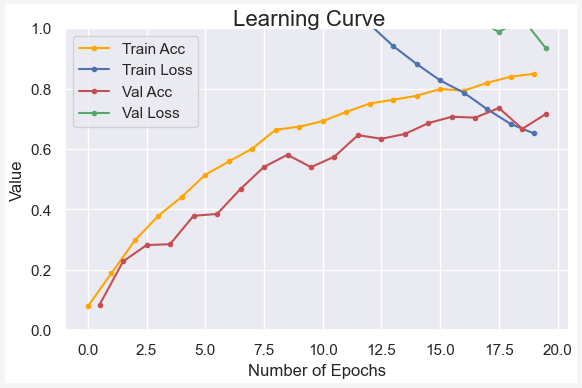

Epoch 1/20
79/79 [==============================] - 1s 16ms/step - loss: 2.8615 - accuracy: 0.2104 - val_loss: 2.1455 - val_accuracy: 0.3300
Epoch 2/20
79/79 [==============================] - 1s 16ms/step - loss: 1.5159 - accuracy: 0.5496 - val_loss: 1.3756 - val_accuracy: 0.5640
Epoch 3/20
79/79 [==============================] - 1s 16ms/step - loss: 0.8170 - accuracy: 0.7552 - val_loss: 0.8847 - val_accuracy: 0.7550
Epoch 4/20
79/79 [==============================] - 1s 15ms/step - loss: 0.5334 - accuracy: 0.8464 - val_loss: 1.1498 - val_accuracy: 0.6090
Epoch 5/20
79/79 [==============================] - 1s 15ms/step - loss: 0.3977 - accuracy: 0.8840 - val_loss: 0.6835 - val_accuracy: 0.7670
Epoch 6/20
79/79 [==============================] - 1s 15ms/step - loss: 0.2340 - accuracy: 0.9440 - val_loss: 0.6726 - val_accuracy: 0.7620
Epoch 7/20
79/79 [==============================] - 1s 15ms/step - loss: 0.2099 - accuracy: 0.9488 - val_loss: 0.7422 - val_accuracy: 0.7540
Epoch 8/20
79

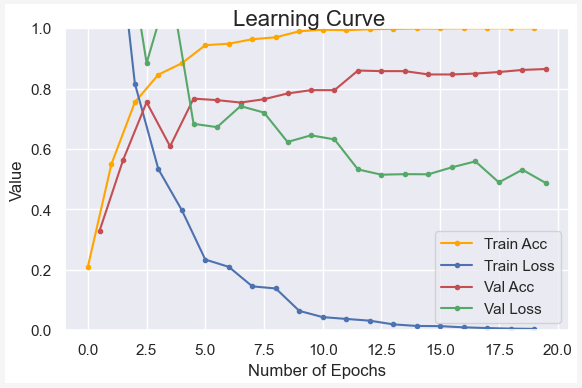

Epoch 1/20
79/79 [==============================] - 1s 16ms/step - loss: 4.9430 - accuracy: 0.0792 - val_loss: 3.6581 - val_accuracy: 0.0500
Epoch 2/20
79/79 [==============================] - 1s 15ms/step - loss: 2.4877 - accuracy: 0.2708 - val_loss: 1.7323 - val_accuracy: 0.4250
Epoch 3/20
79/79 [==============================] - 1s 16ms/step - loss: 1.3078 - accuracy: 0.5792 - val_loss: 1.5290 - val_accuracy: 0.5380
Epoch 4/20
79/79 [==============================] - 1s 15ms/step - loss: 0.9808 - accuracy: 0.6968 - val_loss: 1.1982 - val_accuracy: 0.6150
Epoch 5/20
79/79 [==============================] - 1s 16ms/step - loss: 0.5819 - accuracy: 0.8016 - val_loss: 1.1457 - val_accuracy: 0.6390
Epoch 6/20
79/79 [==============================] - 1s 15ms/step - loss: 0.4112 - accuracy: 0.8572 - val_loss: 0.9225 - val_accuracy: 0.7400
Epoch 7/20
79/79 [==============================] - 1s 15ms/step - loss: 0.2235 - accuracy: 0.9268 - val_loss: 0.8824 - val_accuracy: 0.7840
Epoch 8/20
79

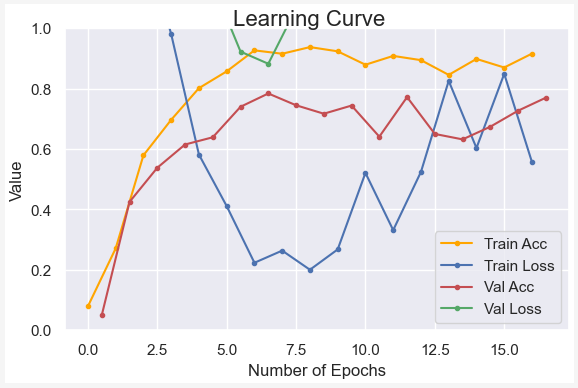

Epoch 1/20
79/79 [==============================] - 1s 17ms/step - loss: 260.2955 - accuracy: 0.0436 - val_loss: 41.3275 - val_accuracy: 0.0320
Epoch 2/20
79/79 [==============================] - 1s 16ms/step - loss: 19.6028 - accuracy: 0.0396 - val_loss: 40.4413 - val_accuracy: 0.0200
Epoch 3/20
79/79 [==============================] - 1s 15ms/step - loss: 18.7224 - accuracy: 0.0440 - val_loss: 20.7394 - val_accuracy: 0.0460
Epoch 4/20
79/79 [==============================] - 1s 16ms/step - loss: 23.3298 - accuracy: 0.0400 - val_loss: 19.8183 - val_accuracy: 0.0280
Epoch 5/20
79/79 [==============================] - 1s 15ms/step - loss: 21.3747 - accuracy: 0.0432 - val_loss: 40.2555 - val_accuracy: 0.0420
Epoch 6/20
79/79 [==============================] - 1s 15ms/step - loss: 26.4181 - accuracy: 0.0432 - val_loss: 21.8268 - val_accuracy: 0.0380
Epoch 7/20
79/79 [==============================] - 1s 16ms/step - loss: 42.0976 - accuracy: 0.0416 - val_loss: 130.5121 - val_accuracy: 0.02

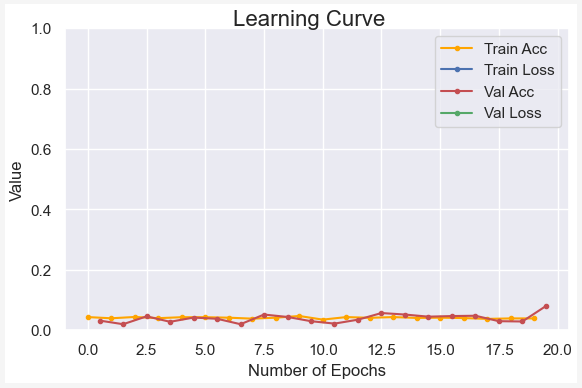

[[0.0001, 0.7360000014305115, 0.722000002861023], [0.001, 0.8650000095367432, 0.878000020980835], [0.01, 0.7839999794960022, 0.7820000052452087], [0.1, 0.07999999821186066, 0.07100000232458115]]


In [52]:
# Learning rate
res=[]
for lr in [0.1, 1, 10,100]:
    valaccl, testaccl, history_cnn_l, discard = do_all2(model_cnn,hiddensizes2, actfn, optimizer, lr*learningrate, n_train, n_valid, n_epochs, batch_size)
    plot_history(history_cnn_l)
    res += [[lr*learningrate,valaccl,testaccl]]
print(res)

In [53]:
#best accuarcy on validation and testing set : 0.8849999904632568, 0.8790000081062317 (0.001)

In [54]:
valaccl_, testaccl_, history_cnn_l_best, discard = do_all2(model_cnn,hiddensizes2, actfn, optimizer, 0.001, n_train, n_valid, n_epochs, batch_size)

Epoch 1/20
79/79 [==============================] - 1s 16ms/step - loss: 2.8251 - accuracy: 0.2224 - val_loss: 2.3757 - val_accuracy: 0.2510
Epoch 2/20
79/79 [==============================] - 1s 15ms/step - loss: 1.5165 - accuracy: 0.5424 - val_loss: 1.3848 - val_accuracy: 0.5580
Epoch 3/20
79/79 [==============================] - 1s 15ms/step - loss: 0.8382 - accuracy: 0.7496 - val_loss: 0.9137 - val_accuracy: 0.7020
Epoch 4/20
79/79 [==============================] - 1s 14ms/step - loss: 0.5685 - accuracy: 0.8244 - val_loss: 1.1598 - val_accuracy: 0.6110
Epoch 5/20
79/79 [==============================] - 1s 15ms/step - loss: 0.4428 - accuracy: 0.8700 - val_loss: 0.7254 - val_accuracy: 0.7600
Epoch 6/20
79/79 [==============================] - 1s 15ms/step - loss: 0.2624 - accuracy: 0.9336 - val_loss: 0.7118 - val_accuracy: 0.7710
Epoch 7/20
79/79 [==============================] - 1s 15ms/step - loss: 0.1895 - accuracy: 0.9588 - val_loss: 0.5471 - val_accuracy: 0.8210
Epoch 8/20
79

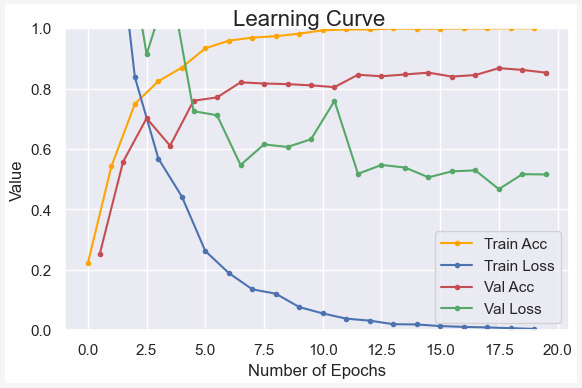

In [55]:
cnn_lr_plot = plot_history(history_cnn_l_best)

#### DNN

Epoch 1/20
79/79 [==============================] - 0s 5ms/step - loss: 3.1752 - accuracy: 0.0928 - val_loss: 3.0358 - val_accuracy: 0.0860
Epoch 2/20
79/79 [==============================] - 0s 3ms/step - loss: 2.8457 - accuracy: 0.1996 - val_loss: 2.7353 - val_accuracy: 0.2400
Epoch 3/20
79/79 [==============================] - 0s 3ms/step - loss: 2.5575 - accuracy: 0.3160 - val_loss: 2.4865 - val_accuracy: 0.3020
Epoch 4/20
79/79 [==============================] - 0s 3ms/step - loss: 2.3102 - accuracy: 0.3780 - val_loss: 2.2444 - val_accuracy: 0.3720
Epoch 5/20
79/79 [==============================] - 0s 4ms/step - loss: 2.0953 - accuracy: 0.4216 - val_loss: 2.1196 - val_accuracy: 0.3890
Epoch 6/20
79/79 [==============================] - 0s 3ms/step - loss: 1.9237 - accuracy: 0.4712 - val_loss: 1.9989 - val_accuracy: 0.4360
Epoch 7/20
79/79 [==============================] - 0s 3ms/step - loss: 1.7872 - accuracy: 0.5108 - val_loss: 1.9001 - val_accuracy: 0.4590
Epoch 8/20
79/79 [==

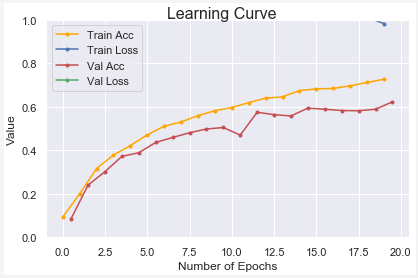

Epoch 1/20
79/79 [==============================] - 0s 4ms/step - loss: 2.9410 - accuracy: 0.1560 - val_loss: 2.8461 - val_accuracy: 0.1230
Epoch 2/20
79/79 [==============================] - 0s 3ms/step - loss: 2.1074 - accuracy: 0.3228 - val_loss: 2.0300 - val_accuracy: 0.3150
Epoch 3/20
79/79 [==============================] - 0s 3ms/step - loss: 1.6943 - accuracy: 0.4472 - val_loss: 1.7496 - val_accuracy: 0.4200
Epoch 4/20
79/79 [==============================] - 0s 3ms/step - loss: 1.4615 - accuracy: 0.5080 - val_loss: 1.6491 - val_accuracy: 0.4370
Epoch 5/20
79/79 [==============================] - 0s 3ms/step - loss: 1.2942 - accuracy: 0.5892 - val_loss: 1.6414 - val_accuracy: 0.4580
Epoch 6/20
79/79 [==============================] - 0s 3ms/step - loss: 1.1441 - accuracy: 0.6300 - val_loss: 1.5431 - val_accuracy: 0.5180
Epoch 7/20
79/79 [==============================] - 0s 3ms/step - loss: 1.0481 - accuracy: 0.6620 - val_loss: 1.3887 - val_accuracy: 0.5520
Epoch 8/20
79/79 [==

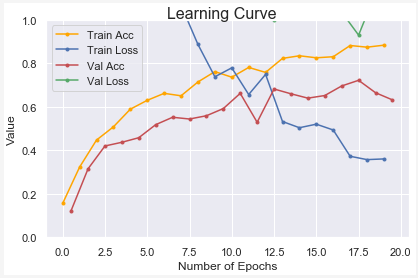

Epoch 1/20
79/79 [==============================] - 0s 4ms/step - loss: 4.8633 - accuracy: 0.0524 - val_loss: 3.7192 - val_accuracy: 0.0350
Epoch 2/20
79/79 [==============================] - 0s 3ms/step - loss: 3.0168 - accuracy: 0.1360 - val_loss: 3.8003 - val_accuracy: 0.1170
Epoch 3/20
79/79 [==============================] - 0s 3ms/step - loss: 2.6435 - accuracy: 0.2156 - val_loss: 2.7007 - val_accuracy: 0.1430
Epoch 4/20
79/79 [==============================] - 0s 3ms/step - loss: 2.5484 - accuracy: 0.2376 - val_loss: 2.9171 - val_accuracy: 0.1870
Epoch 5/20
79/79 [==============================] - 0s 3ms/step - loss: 2.3680 - accuracy: 0.2820 - val_loss: 2.8709 - val_accuracy: 0.2480
Epoch 6/20
79/79 [==============================] - 0s 3ms/step - loss: 2.1618 - accuracy: 0.3300 - val_loss: 3.0310 - val_accuracy: 0.2260
Epoch 7/20
79/79 [==============================] - 0s 3ms/step - loss: 2.1919 - accuracy: 0.3368 - val_loss: 2.4888 - val_accuracy: 0.2800
Epoch 8/20
79/79 [==

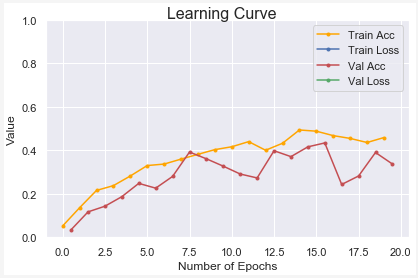

Epoch 1/20
79/79 [==============================] - 1s 7ms/step - loss: 145.7824 - accuracy: 0.0476 - val_loss: 27.1003 - val_accuracy: 0.0350
Epoch 2/20
79/79 [==============================] - 0s 6ms/step - loss: 14.1108 - accuracy: 0.0416 - val_loss: 12.6944 - val_accuracy: 0.0200
Epoch 3/20
79/79 [==============================] - 0s 4ms/step - loss: 11.9359 - accuracy: 0.0420 - val_loss: 11.8861 - val_accuracy: 0.0290
Epoch 4/20
79/79 [==============================] - 0s 4ms/step - loss: 10.0900 - accuracy: 0.0504 - val_loss: 7.6860 - val_accuracy: 0.0520
Epoch 5/20
79/79 [==============================] - 0s 4ms/step - loss: 7.3600 - accuracy: 0.0476 - val_loss: 7.5269 - val_accuracy: 0.0420
Epoch 6/20
79/79 [==============================] - 0s 4ms/step - loss: 6.8029 - accuracy: 0.0368 - val_loss: 10.3375 - val_accuracy: 0.0350
Epoch 7/20
79/79 [==============================] - 0s 3ms/step - loss: 5.9184 - accuracy: 0.0416 - val_loss: 4.8697 - val_accuracy: 0.0480
Epoch 8/20


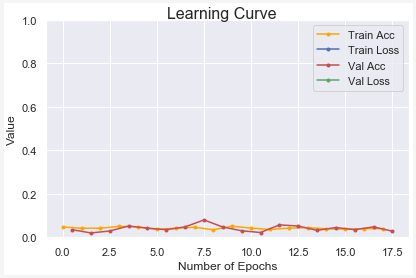

[[0.0001, 0.6230000257492065, 0.6119999885559082], [0.001, 0.722000002861023, 0.6299999952316284], [0.01, 0.4339999854564667, 0.3370000123977661], [0.1, 0.07999999821186066, 0.07100000232458115]]


In [131]:
# Learning rate
hiddensizes2=[64,128,256]
res=[]
for lr in [0.1, 1, 10,100]:
    valaccl_, testaccl_, history_dnn_l, discard = do_all2(model_dnn,hiddensizes2, actfn, optimizer, lr*learningrate, n_train, n_valid, n_epochs, batch_size)
    plot_history(history_dnn_l)
    res += [[lr*learningrate,valaccl_,testaccl_]]
print(res)

In [132]:
#best accuarcy on validation and testing set : 0.722000002861023, 0.6299999952316284 (lr = 0.001)

In [133]:
valaccl_, testaccl_, history_dnn_l_best, discard = do_all2(model_dnn,hiddensizes2, actfn, optimizer, 0.001, n_train, n_valid, n_epochs, batch_size)

Epoch 1/20
79/79 [==============================] - 0s 4ms/step - loss: 3.0206 - accuracy: 0.1296 - val_loss: 2.6853 - val_accuracy: 0.1550
Epoch 2/20
79/79 [==============================] - 0s 3ms/step - loss: 2.1252 - accuracy: 0.3292 - val_loss: 1.9974 - val_accuracy: 0.3370
Epoch 3/20
79/79 [==============================] - 0s 4ms/step - loss: 1.7639 - accuracy: 0.4392 - val_loss: 1.6410 - val_accuracy: 0.4890
Epoch 4/20
79/79 [==============================] - 0s 3ms/step - loss: 1.5364 - accuracy: 0.4980 - val_loss: 1.7936 - val_accuracy: 0.3910
Epoch 5/20
79/79 [==============================] - 0s 3ms/step - loss: 1.3375 - accuracy: 0.5600 - val_loss: 1.8114 - val_accuracy: 0.3870
Epoch 6/20
79/79 [==============================] - 0s 4ms/step - loss: 1.2052 - accuracy: 0.6012 - val_loss: 1.4767 - val_accuracy: 0.5220
Epoch 7/20
79/79 [==============================] - 0s 4ms/step - loss: 1.0783 - accuracy: 0.6380 - val_loss: 1.2697 - val_accuracy: 0.6200
Epoch 8/20
79/79 [==

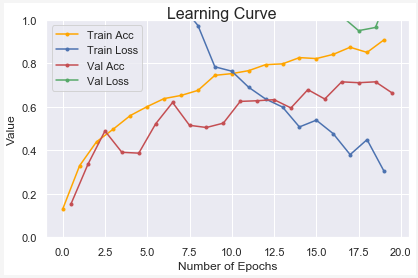

In [134]:
plot_history(history_dnn_l_best)

#### Observation: 
-  We see the highest accuracy for  CNN model when the learning rate is 0.001(default rate for Adam)
- We see the highest accuracy  for DNN model when  the learning rate is 0.001(default rate for Adam)

### III. Exploring epoch:

In [264]:
def create_model_cnn():
    
    model = keras.models.Sequential()
    
    #input layer goes into this 2D convolution
    model.add(keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(2,2), activation=actfn, padding="same",kernel_initializer="he_uniform", 
                                  input_shape=[28, 28, 1]))  
    # Pool (downsize)
    model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))         
    
    # 2nd Conv
    model.add(keras.layers.Conv2D(filters=128, kernel_size=(3,3), strides= (2,2), padding="same", activation="elu"))  # 2nd Conv
    
    # Pool (downsize)
    model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))          
    
    # 3rd Conv
    model.add(keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides= (2,2), padding="same", activation="elu"))  # 2nd Conv
    
    # unravel into a 1D vector 
    model.add(keras.layers.Flatten())  
    
    #dense layer
    model.add(keras.layers.Dense(25, activation = "softmax"))  
    
    #compile the model
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
    
    return model

In [265]:
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

seed = 7
np.random.seed(seed)

model = KerasClassifier(build_fn = create_model_cnn, batch_size = 50, verbose=0)

batch_size = [50]

#exploring epoch in ranges 20 to 100
epochs = [20,40,50,70,80,100]

param_grid = dict(batch_size=batch_size, epochs=epochs)

#Grid search for best parameter
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1,cv=5)

grid_result = grid.fit(X_train[:1000], y_train[:1000])

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.870000 using {'batch_size': 50, 'epochs': 80}


In [269]:
valacc_g_cnn, testacc_g_cnn, history_g_cnn, model_g_cnn = do_all2(model_cnn,hiddensizes2, actfn, optimizer, learningrate, n_train, n_valid, 80, batch_size)

Epoch 1/80
79/79 [==============================] - 2s 24ms/step - loss: 2.7449 - accuracy: 0.2076 - val_loss: 2.1391 - val_accuracy: 0.3160
Epoch 2/80
79/79 [==============================] - 2s 23ms/step - loss: 1.4118 - accuracy: 0.5544 - val_loss: 1.3628 - val_accuracy: 0.5710
Epoch 3/80
79/79 [==============================] - 2s 23ms/step - loss: 0.7711 - accuracy: 0.7540 - val_loss: 0.9635 - val_accuracy: 0.6730
Epoch 4/80
79/79 [==============================] - 2s 23ms/step - loss: 0.5248 - accuracy: 0.8380 - val_loss: 0.8729 - val_accuracy: 0.6950
Epoch 5/80
79/79 [==============================] - 2s 23ms/step - loss: 0.3547 - accuracy: 0.8944 - val_loss: 0.6892 - val_accuracy: 0.7700
Epoch 6/80
79/79 [==============================] - 2s 26ms/step - loss: 0.2485 - accuracy: 0.9264 - val_loss: 0.6383 - val_accuracy: 0.7950
Epoch 7/80
79/79 [==============================] - 2s 24ms/step - loss: 0.1994 - accuracy: 0.9488 - val_loss: 0.5360 - val_accuracy: 0.8190
Epoch 8/80
79

In [271]:
testres_g_cnn = model_g_cnn.evaluate(X_test, y_test, verbose=0)
print('test loss, test acc:', testres_g_cnn)

test loss, test acc: [0.6563588976860046, 0.8700000047683716]


In [209]:
def create_model_dnn():
    
    model = keras.models.Sequential()
    
    #get same size inputs
    model.add(keras.layers.Flatten(input_shape = [28 , 28]))    
    
    #add layers
    model.add(keras.layers.Dense(64, activation = "elu",kernel_initializer="he_uniform"))
    model.add(keras.layers.Dense(128, activation = "elu",kernel_initializer="he_uniform"))
    model.add(keras.layers.Dense(256, activation = "elu",kernel_initializer="he_uniform"))
        
    model.add(keras.layers.Dense(25, activation = "softmax"))  
    
    #compile the model
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])
    return model

In [211]:
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

model = KerasClassifier(build_fn = create_model_dnn, batch_size = 50, verbose=0)

batch_size = [50]
epochs = [20,50,70,80,90,100]

param_grid = dict(batch_size=batch_size, epochs=epochs)

#grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1,cv=5)

grid_result = grid.fit(X_train[:1000], y_train[:1000])

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.772000 using {'batch_size': 50, 'epochs': 90}


In [212]:
valacc_g_dnn, testacc_g_dnn, history_g_dnn, model_g_dnn = do_all2(model_dnn,hiddensizes3, actfn, optimizer, learningrate, n_train, n_valid, 100, batch_size)

Epoch 1/100
79/79 [==============================] - 0s 4ms/step - loss: 2.9169 - accuracy: 0.1412 - val_loss: 2.5105 - val_accuracy: 0.2370
Epoch 2/100
79/79 [==============================] - 0s 3ms/step - loss: 2.0632 - accuracy: 0.3384 - val_loss: 1.9998 - val_accuracy: 0.3990
Epoch 3/100
79/79 [==============================] - 0s 3ms/step - loss: 1.6538 - accuracy: 0.4684 - val_loss: 1.6785 - val_accuracy: 0.4520
Epoch 4/100
79/79 [==============================] - 0s 3ms/step - loss: 1.4150 - accuracy: 0.5372 - val_loss: 1.6337 - val_accuracy: 0.4640
Epoch 5/100
79/79 [==============================] - 0s 3ms/step - loss: 1.3498 - accuracy: 0.5540 - val_loss: 1.6797 - val_accuracy: 0.4790
Epoch 6/100
79/79 [==============================] - 0s 3ms/step - loss: 1.2693 - accuracy: 0.5736 - val_loss: 1.5113 - val_accuracy: 0.5210
Epoch 7/100
79/79 [==============================] - 0s 3ms/step - loss: 1.1209 - accuracy: 0.6324 - val_loss: 1.4473 - val_accuracy: 0.5730
Epoch 8/100
7

In [213]:
testres = model_g_dnn.evaluate(X_test, y_test, verbose=0)
print('test loss, test acc:', testres)

test loss, test acc: [1.018568992614746, 0.7459999918937683]


#### Observation: 
- We see the best performance of  CNN model when the number of epoch is equal to 80 
-  We see the best performance of  DNN model when the number of epoch is equal to 90

***
#### We can observe that CNN model has the lowest loss and highest accuracy compared to DNN
#### I will optimise CNN further
***

In [548]:
#set num of epoch equal to 80
n_epochs = 80

### IV. Exploring strides for CNN:

### #1 take (3,3 strides)

In [60]:
def model_f1(hiddensizes, actfn, optimizer, learningrate=0):
  
    model = keras.models.Sequential()
    
    #input layer goes into this 2D convolution
    model.add(keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(3,3), activation=actfn, padding="same",kernel_initializer="he_uniform", 
                                  input_shape=[28, 28, 1]))
    # Pool (downsize)
    model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))          
    
    # 2nd Conv
    model.add(keras.layers.Conv2D(filters=128, kernel_size=(3,3), strides= (3,3), padding="same", activation=actfn,kernel_initializer="he_uniform"))  
    # Pool (downsize)
    model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))          
    
    # 3rd Conv
    model.add(keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides= (3,3), padding="same", activation=actfn,kernel_initializer="he_uniform"))  
    
    # unravel into a 1D vector
    model.add(keras.layers.Flatten()) 
    
    #dense layer
    model.add(keras.layers.Dense(25, activation = "softmax"))  
    
    #compile the model
    model.compile(loss="categorical_crossentropy", optimizer=optimizer(lr=learningrate), metrics=["accuracy"]) 
    # use "categorical_crossentropy" loss as labels are one hot encoded
    
    return model

valacc, testacc, history_f1, model_f1 = do_all2(model_f1,[64,128,256], actfn, optimizer, learningrate, n_train, n_valid,
                                                n_epochs,batch_size)

Epoch 1/20
79/79 [==============================] - 1s 10ms/step - loss: 2.9406 - accuracy: 0.1448 - val_loss: 2.6447 - val_accuracy: 0.1500
Epoch 2/20
79/79 [==============================] - 1s 9ms/step - loss: 2.0333 - accuracy: 0.3616 - val_loss: 1.8382 - val_accuracy: 0.4570
Epoch 3/20
79/79 [==============================] - 1s 9ms/step - loss: 1.4894 - accuracy: 0.5260 - val_loss: 1.5468 - val_accuracy: 0.5040
Epoch 4/20
79/79 [==============================] - 1s 9ms/step - loss: 1.1763 - accuracy: 0.6396 - val_loss: 1.3845 - val_accuracy: 0.5470
Epoch 5/20
79/79 [==============================] - 1s 9ms/step - loss: 0.8904 - accuracy: 0.7288 - val_loss: 1.2431 - val_accuracy: 0.5890
Epoch 6/20
79/79 [==============================] - 1s 9ms/step - loss: 0.7022 - accuracy: 0.7752 - val_loss: 1.1188 - val_accuracy: 0.6440
Epoch 7/20
79/79 [==============================] - 1s 9ms/step - loss: 0.5841 - accuracy: 0.8152 - val_loss: 0.9355 - val_accuracy: 0.6580
Epoch 8/20
79/79 [=

In [61]:
# results (loss and accuracy)
testres = model_f1.evaluate(X_test, y_test, verbose=0)

print("Test set")
print('loss, accuracy:', testres)

Test set
loss, accuracy: [0.7895000576972961, 0.7670000195503235]


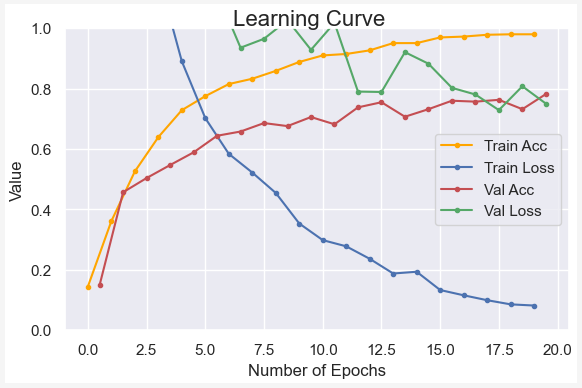

In [62]:
plot_history(history_f1)

### #2 take 2 strides

In [63]:
def model_f2(hiddensizes, actfn, optimizer, learningrate=0):
    
    model = keras.models.Sequential()
    
    #input layer goes into this 2D convolution
    model.add(keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=2, activation=actfn, padding="same",kernel_initializer="he_uniform", 
                                  input_shape=[28, 28, 1]))
    # Pool (downsize)
    model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))          
    
    # 2nd Conv
    model.add(keras.layers.Conv2D(filters=128, kernel_size=(3,3), strides= 2, padding="same", activation=actfn,kernel_initializer="he_uniform"))  
    # Pool (downsize)
    model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))          
    
    # 3rd Conv
    model.add(keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides= 2, padding="same", activation=actfn,kernel_initializer="he_uniform"))  
    
    # unravel into a 1D vector
    model.add(keras.layers.Flatten()) 
    
    #dense layer
    model.add(keras.layers.Dense(25, activation = "softmax"))  
    
    #compile the model
    model.compile(loss="categorical_crossentropy", optimizer=optimizer(lr=learningrate), metrics=["accuracy"]) 
    # use "categorical_crossentropy" loss as labels are one hot encoded
      
    return model

valacc, testacc, history_f2, model_f2 = do_all2(model_f2,[64,128,256], actfn, optimizer, learningrate, n_train, n_valid,
                                                n_epochs,batch_size)

Epoch 1/20
79/79 [==============================] - 1s 16ms/step - loss: 2.7733 - accuracy: 0.2264 - val_loss: 2.2796 - val_accuracy: 0.2730
Epoch 2/20
79/79 [==============================] - 1s 14ms/step - loss: 1.4411 - accuracy: 0.5632 - val_loss: 1.3400 - val_accuracy: 0.5470
Epoch 3/20
79/79 [==============================] - 1s 15ms/step - loss: 0.7784 - accuracy: 0.7644 - val_loss: 0.8617 - val_accuracy: 0.7410
Epoch 4/20
79/79 [==============================] - 1s 16ms/step - loss: 0.5141 - accuracy: 0.8484 - val_loss: 1.2026 - val_accuracy: 0.6160
Epoch 5/20
79/79 [==============================] - 1s 15ms/step - loss: 0.4139 - accuracy: 0.8820 - val_loss: 0.7164 - val_accuracy: 0.7570
Epoch 6/20
79/79 [==============================] - 1s 15ms/step - loss: 0.2583 - accuracy: 0.9304 - val_loss: 0.7353 - val_accuracy: 0.7810
Epoch 7/20
79/79 [==============================] - 1s 14ms/step - loss: 0.1736 - accuracy: 0.9592 - val_loss: 0.5700 - val_accuracy: 0.8260
Epoch 8/20
79

In [64]:
# results (loss and accuracy)
testres = model_f2.evaluate(X_test, y_test, verbose=0)

print("Test set")
print('loss, accuracy:', testres)

Test set
loss, accuracy: [0.5519564747810364, 0.8669999837875366]


In [65]:
# results (loss and accuracy)
testres_valid = model_f2.evaluate(X_valid, y_valid, verbose=0)

print("Valid set")
print('loss, accuracy:', testres_valid)

Valid set
loss, accuracy: [0.4875395596027374, 0.8690000176429749]


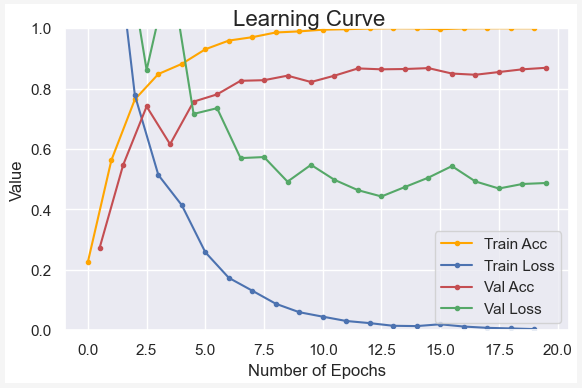

In [66]:
plot_history(history_f2)

### #3 Take a combination :(2,2),2,(2,2)

In [67]:

def model_f3(hiddensizes, actfn, optimizer, learningrate=0):
    
    model = keras.models.Sequential()
    
    #input layer goes into this 2D convolution
    model.add(keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(2,2), activation=actfn, padding="same",kernel_initializer="he_uniform", 
                                  input_shape=[28, 28, 1]))
    # Pool (downsize)
    model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))          
    
    # 2nd Conv
    model.add(keras.layers.Conv2D(filters=128, kernel_size=(3,3), strides= 2, padding="same", activation=actfn,kernel_initializer="he_uniform"))  
    # Pool (downsize)
    model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))          
    
    # 3rd Conv
    model.add(keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides= (2,2), padding="same", activation=actfn,kernel_initializer="he_uniform"))  
    
    # unravel into a 1D vector
    model.add(keras.layers.Flatten()) 
    
    #dense layer
    model.add(keras.layers.Dense(25, activation = "softmax"))  
    
    #compile the model
    model.compile(loss="categorical_crossentropy", optimizer=optimizer(lr=learningrate), metrics=["accuracy"]) 
    # use "categorical_crossentropy" loss as labels are one hot encoded
       
    return model

valacc, testacc, history_f3, model_f3 = do_all2(model_f3,[64,128,256], actfn, optimizer, learningrate, n_train, n_valid,
                                                n_epochs,batch_size)

Epoch 1/20
79/79 [==============================] - 1s 16ms/step - loss: 2.7679 - accuracy: 0.2272 - val_loss: 2.1263 - val_accuracy: 0.2730
Epoch 2/20
79/79 [==============================] - 1s 14ms/step - loss: 1.3917 - accuracy: 0.5772 - val_loss: 1.2758 - val_accuracy: 0.5940
Epoch 3/20
79/79 [==============================] - 1s 14ms/step - loss: 0.7661 - accuracy: 0.7712 - val_loss: 0.8359 - val_accuracy: 0.7390
Epoch 4/20
79/79 [==============================] - 1s 15ms/step - loss: 0.5022 - accuracy: 0.8492 - val_loss: 1.0496 - val_accuracy: 0.6510
Epoch 5/20
79/79 [==============================] - 1s 14ms/step - loss: 0.3541 - accuracy: 0.9028 - val_loss: 0.6631 - val_accuracy: 0.7870
Epoch 6/20
79/79 [==============================] - 1s 14ms/step - loss: 0.2384 - accuracy: 0.9352 - val_loss: 0.6896 - val_accuracy: 0.7790
Epoch 7/20
79/79 [==============================] - 1s 14ms/step - loss: 0.1784 - accuracy: 0.9580 - val_loss: 0.6383 - val_accuracy: 0.8000
Epoch 8/20
79

In [68]:
# results (loss and accuracy)
testres = model_f3.evaluate(X_test, y_test, verbose=0)

print("Test set")
print('loss, accuracy:', testres)

Test set
loss, accuracy: [0.5563642978668213, 0.871999979019165]


In [69]:
# results (loss and accuracy)
testres_valid = model_f3.evaluate(X_valid, y_valid, verbose=0)

print("Valid set")
print('loss, accuracy:', testres_valid)

Valid set
loss, accuracy: [0.47809165716171265, 0.8709999918937683]


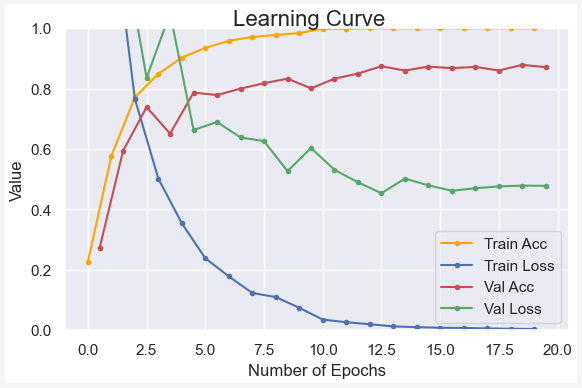

In [70]:
plot_history(history_f3)

#### Final Model: The above model 'model_f3' is the final model

### Summary

##### 1. First i compared the model accuracy for different number and size of layers
I found that for CNN, the best hiddensizes are [64,128,256]

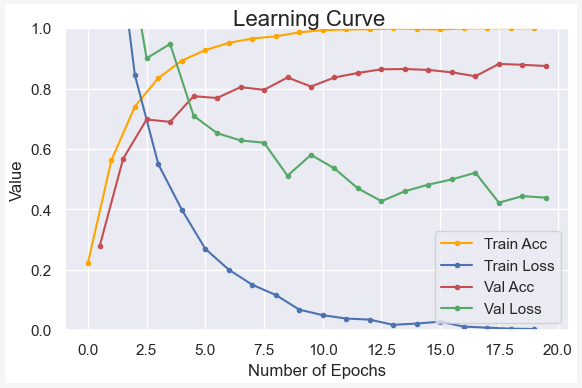

In [71]:
#training and validation accuracy and loss plot for CNN with hiddensizes [64,128,256]
plot_history(history_cnn_layer2)

for DNN the best hiddensizes are also [64,128,256]

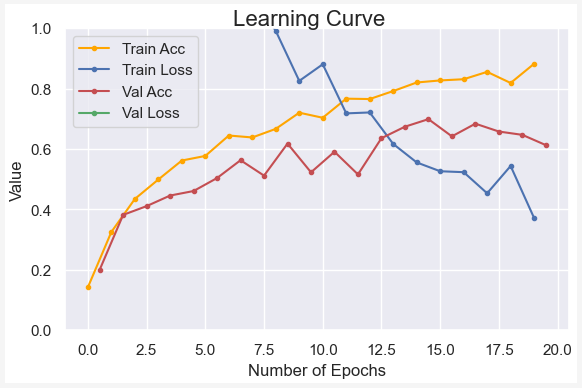

In [72]:
#training and validation accuracy and loss plot for DNN with hiddensizes [64,128,256]
plot_history(history_dnn_layer3)

##### 2. I explored the model accuracy for different learning rates
- I found that for both CNN and DNN, the best learning rate is the default rate(0.001)
- As learning rate increased,accuracy decreases 

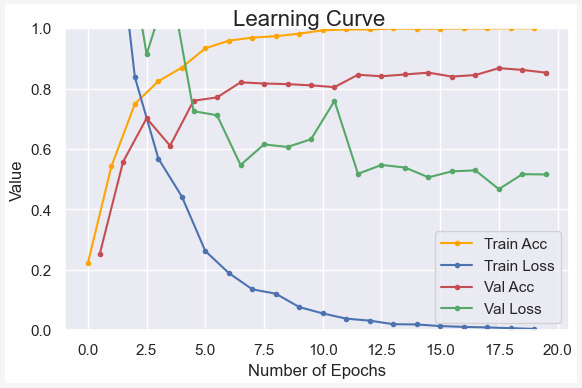

In [73]:
#training and validation accuracy and loss plot for CNN with best learning rate 0.001
plot_history(history_cnn_l_best)

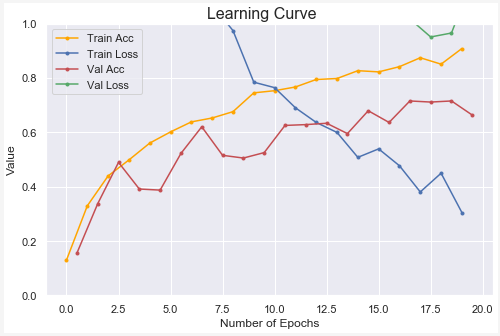

In [140]:
#training and validation accuracy and loss plot for DNN with best learning rate 0.001
plot_history(history_dnn_l_best)

##### 3. I explored the model accuracy for different number of epochs by Grid Search
- I found that the for CNN , number of epoch equal 80 is best performimg model in terms of accuracy.
- CNN:test loss, test acc: [0.6563588976860046, 0.8700000047683716]


- I found that the for DNN , number of epoch equal 90 is best performimg model in terms of accuracy.
- DNN: test loss, test acc: [1.018568992614746, 0.7459999918937683]

##### 4. I explored the model accuracy for different number of strides for CNN
For Strides = (3,3), all Strides = 2, all Strides = (2,2) & 2 & (2,2) respectively:

Plot for different number of strides


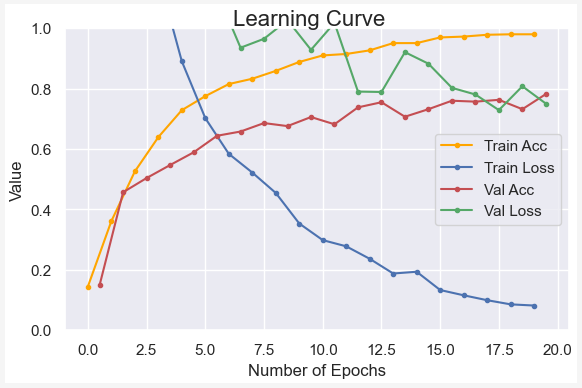

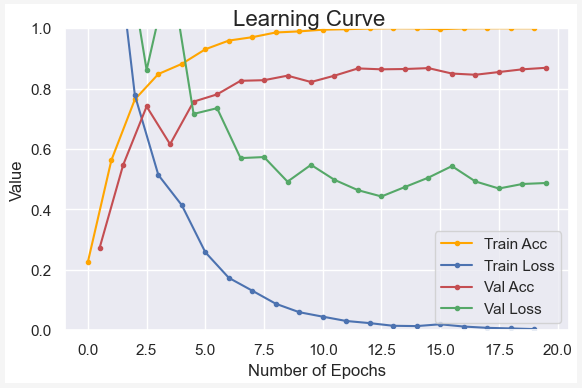

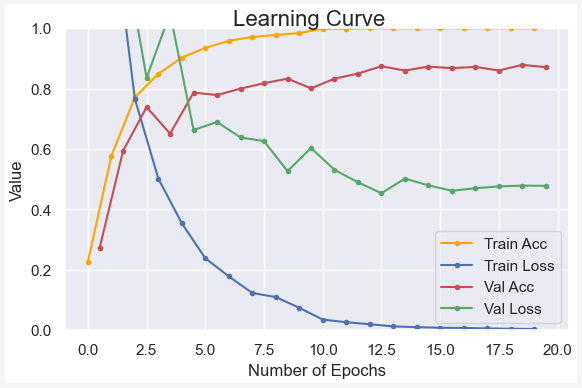

<Figure size 600x400 with 0 Axes>

In [75]:
print("Plot for different number of strides")

plot_history(history_f1)
plot_history(history_f2)
plot_history(history_f3)

plt.tight_layout()

#### My final model
- My final model is model_f3, with 3 hidden layers: 64,128,256 , number of epoch:80 ,number of strides:(2,2) & 2 & (2,2) and loss: 0.5563642978668213 and accuracy:  0.871999979019165(on test set)
 
 
- I chose this network has it had the lowest loss and highest accuracy when compared to other models.The plot of loss and accuracy was also good when compared to other networks as in the loss curve for validation data was decreasing and the accuracy curve for validation data was increasing.


#### Results 


In [76]:
#the confusion matrix 

from sklearn.metrics import confusion_matrix

y_pred_final = model_f3.predict_classes(X_test, verbose=0)

rounded_labels = np.argmax(y_test, axis = 1)

cm = confusion_matrix(rounded_labels, y_pred_final)
print(cm)

[[44  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 59  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0]
 [ 0  0 39  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 32  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  1  0]
 [ 0  0  0  0 71  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 37  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 45  6  0  0  0  0  0  0  0  1  2  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  5 57  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 39  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 39  0  0  0  0  0  0  0  4  0  2  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 23  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  3  0  0  0  4  0  0 43  8  2  0  0  0  3  0  0  0  0  0  0]
 [ 2  0  0  0  0  0  0  0  0  0  0  6 24  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0

- Finding The class that is misclassified the most

In [77]:
from sklearn import metrics

report = metrics.classification_report(rounded_labels, y_pred_final, target_names=["A","B","C","D","E","F","G","H","I","K","L","M","N","O","P","Q","R","S","T","U","V","W","X","Y"])
print(report)

precision    recall  f1-score   support

           A       0.96      1.00      0.98        44
           B       1.00      0.95      0.98        62
           C       0.97      0.97      0.97        40
           D       0.97      0.94      0.96        34
           E       0.95      1.00      0.97        71
           F       0.97      1.00      0.99        37
           G       0.85      0.83      0.84        54
           H       0.80      0.92      0.86        62
           I       0.78      0.91      0.84        43
           K       1.00      0.87      0.93        45
           L       0.77      1.00      0.87        23
           M       0.83      0.68      0.75        63
           N       0.71      0.75      0.73        32
           O       0.94      0.94      0.94        35
           P       1.00      1.00      1.00        58
           Q       0.94      0.94      0.94        18
           R       0.40      0.44      0.42        18
           S       0.76      0.87      0.

In [78]:
#We see that Class R is missclassified the most based on f1 score. Then class T is the second most missclassified.

In [79]:
y_predt = model_f3.predict_classes(X_test)   # use the first three test cases
   
print(class_names[rounded_labels[1:25]])   # names of true test classes
print(class_names[y_predt[1:25]])   # names of these classes predicted

['F' 'K' 'A' 'D' 'V' 'K' 'O' 'D' 'H' 'I' 'I' 'V' 'M' 'H' 'E' 'W' 'A' 'H'
 'H' 'C' 'A' 'V' 'E' 'K']
['F' 'K' 'A' 'D' 'V' 'K' 'O' 'D' 'H' 'I' 'I' 'V' 'M' 'H' 'E' 'W' 'A' 'H'
 'H' 'C' 'A' 'V' 'E' 'K']


In [80]:
print(class_names[rounded_labels[87]])   # names of true test class
print(class_names[y_predt[87]])   # # names of the class predicted

print(class_names[rounded_labels[228]])   # names of true test class
print(class_names[y_predt[228]])   # names of the class predicted

R
V
R
V


Actual class: R
Predicted class: V


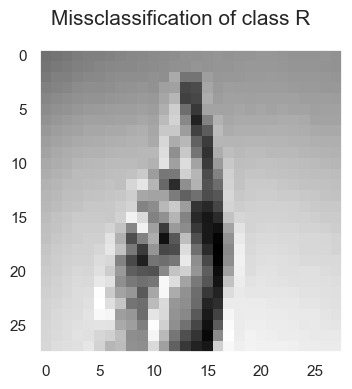

In [81]:
print("Actual class: " + class_names[rounded_labels[87]])   # names of true classes
print("Predicted class:", class_names[y_predt[87]])     # names of the predicted classes 

plt.imshow(X_test[87].reshape((28,28)), cmap="gray")
plt.suptitle("Missclassification of class R ",size = 15)
plt.grid(False)

In [83]:
#the class "R" (actual class no. 16) is mostly missclassified as class "V" (actual class no. 20).

#### Summary and Findings

#I learnt how changing the layer size and number of layers significantly impacts the accuracy of a neural network model. I saw that all my models performed well when there are three layers.

#I also discovered an efficient way to search for good parameters, the grid search. It can be quite time consuming but it provides a good choice of parameter for the model.

#I learnt that when we increase the strides to a larger number for example 3 in this case,the model doesnt perform so well. It causes loss of information. For less training data, stride equal to 2 or (2,2) is a good choice.

#For larger datasets, the number and size of layers can be modified to be increased. Also batch normalisation and dropout layers can be implemented to fit the large training data properly.

***

## 4. Improving the classification performance further

- I will implement new layers: Dropout and Batch Normalization 

### #1 dropout rate = 0.2

In [85]:
def model_d1(hiddensizes, actfn, optimizer, learningrate=0):
    
    model = keras.models.Sequential()
    
    # input layer goes into this 2D convolution
    model.add(keras.layers.Conv2D(filters= 64, kernel_size=(3,3), strides=(2,2), activation=actfn, padding="same",kernel_initializer="he_uniform", 
                                  input_shape=[28, 28, 1]))    
     # Pool (downsize)
    model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))         
    
    # Dropout
    model.add(keras.layers.Dropout(rate=0.2))    
    
    # 2nd Conv
    model.add(keras.layers.Conv2D(filters = 128, kernel_size=(3,3), strides= 2, padding="same", activation=actfn,kernel_initializer="he_uniform")) 
    # Pool (downsize)
    model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
    
    # Dropout
    model.add(keras.layers.Dropout(rate=0.2))
    
    # 3nd Conv
    model.add(keras.layers.Conv2D(filters= 256, kernel_size=(3,3), strides= (2,2), padding="same", activation=actfn,kernel_initializer="he_uniform")) 
    
    # Dropout
    model.add(keras.layers.Dropout(rate=0.2))
    
    # unravel into a 1D vector
    model.add(keras.layers.Flatten())                         

    model.add(keras.layers.Dense(25, activation = "softmax")) 
    model.compile(loss="categorical_crossentropy", optimizer=optimizer(lr=learningrate), metrics=["accuracy"]) 
  
    return model

valacc, testacc, history_drop1, model_drop1 = do_all2(model_d1,[64,128,256], actfn, optimizer, learningrate, n_train, n_valid,
                                                80,batch_size)

Epoch 1/80
79/79 [==============================] - 1s 18ms/step - loss: 3.3405 - accuracy: 0.0748 - val_loss: 3.0229 - val_accuracy: 0.1120
Epoch 2/80
79/79 [==============================] - 1s 16ms/step - loss: 2.6419 - accuracy: 0.2088 - val_loss: 2.1265 - val_accuracy: 0.3450
Epoch 3/80
79/79 [==============================] - 1s 16ms/step - loss: 1.8862 - accuracy: 0.4092 - val_loss: 1.5562 - val_accuracy: 0.5450
Epoch 4/80
79/79 [==============================] - 1s 16ms/step - loss: 1.3470 - accuracy: 0.5568 - val_loss: 1.1874 - val_accuracy: 0.6170
Epoch 5/80
79/79 [==============================] - 1s 17ms/step - loss: 0.9920 - accuracy: 0.6896 - val_loss: 1.0251 - val_accuracy: 0.6610
Epoch 6/80
79/79 [==============================] - 1s 16ms/step - loss: 0.7559 - accuracy: 0.7584 - val_loss: 0.8347 - val_accuracy: 0.7340
Epoch 7/80
79/79 [==============================] - 1s 16ms/step - loss: 0.6162 - accuracy: 0.8032 - val_loss: 0.7118 - val_accuracy: 0.7870
Epoch 8/80
79

In [86]:
testres = model_drop1.evaluate(X_test, y_test, verbose=0)

print("Test set")
print('loss, accuracy:', testres)

Test set
loss, accuracy: [0.4225950539112091, 0.8970000147819519]


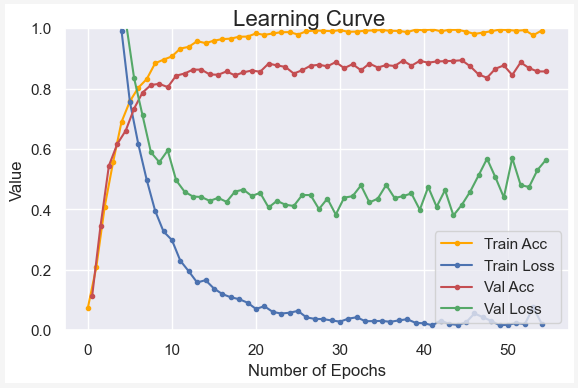

In [87]:
plot_history(history_drop1)

### #2 dropout rate = 0.3,0.3,0.3

In [88]:
def model_d2(hiddensizes, actfn, optimizer, learningrate=0):
    
    model = keras.models.Sequential()
    
    # input layer goes into this 2D convolution
    model.add(keras.layers.Conv2D(filters= 64, kernel_size=(3,3), strides=(2,2), activation=actfn, padding="same",kernel_initializer="he_uniform", 
                                  input_shape=[28, 28, 1]))    
    # Pool (downsize)
    model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))         
    
    # Dropout
    model.add(keras.layers.Dropout(rate=0.3))    
    
    # 2nd Conv
    model.add(keras.layers.Conv2D(filters = 128, kernel_size=(3,3), strides= 2, padding="same", activation=actfn,kernel_initializer="he_uniform")) 
    # Pool (downsize)
    model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
    
    # Dropout
    model.add(keras.layers.Dropout(rate=0.3))
    
    # 3nd Conv
    model.add(keras.layers.Conv2D(filters= 256, kernel_size=(3,3), strides= (2,2), padding="same", activation=actfn,kernel_initializer="he_uniform")) 
    
    # Dropout
    model.add(keras.layers.Dropout(rate=0.3))
    
    # unravel into a 1D vector
    model.add(keras.layers.Flatten())                         

    model.add(keras.layers.Dense(25, activation = "softmax")) 
    model.compile(loss="categorical_crossentropy", optimizer=optimizer(lr=learningrate), metrics=["accuracy"])  
  
    return model

valacc, testacc, history_drop2, model_drop2 = do_all2(model_d2,[64,128,256], actfn, optimizer, learningrate, n_train, n_valid,
                                                80,batch_size)

Epoch 1/80
79/79 [==============================] - 1s 17ms/step - loss: 3.3990 - accuracy: 0.0620 - val_loss: 3.1080 - val_accuracy: 0.0610
Epoch 2/80
79/79 [==============================] - 1s 16ms/step - loss: 2.8287 - accuracy: 0.1668 - val_loss: 2.4373 - val_accuracy: 0.2120
Epoch 3/80
79/79 [==============================] - 1s 16ms/step - loss: 2.1353 - accuracy: 0.3324 - val_loss: 1.7767 - val_accuracy: 0.4700
Epoch 4/80
79/79 [==============================] - 1s 16ms/step - loss: 1.5597 - accuracy: 0.4980 - val_loss: 1.3293 - val_accuracy: 0.5570
Epoch 5/80
79/79 [==============================] - 1s 15ms/step - loss: 1.1532 - accuracy: 0.6228 - val_loss: 1.0973 - val_accuracy: 0.6510
Epoch 6/80
79/79 [==============================] - 1s 16ms/step - loss: 0.8946 - accuracy: 0.7092 - val_loss: 0.9309 - val_accuracy: 0.6710
Epoch 7/80
79/79 [==============================] - 1s 15ms/step - loss: 0.7392 - accuracy: 0.7448 - val_loss: 0.7875 - val_accuracy: 0.7410
Epoch 8/80
79

In [89]:
testres = model_drop2.evaluate(X_valid, y_valid, verbose=0)

print("Valid set")
print('loss, accuracy:', testres)

Valid set
loss, accuracy: [0.3588753938674927, 0.9089999794960022]


In [90]:
testres = model_drop2.evaluate(X_test, y_test, verbose=0)

print("Test set")
print('loss, accuracy:', testres)

Test set
loss, accuracy: [0.4710087180137634, 0.8840000033378601]


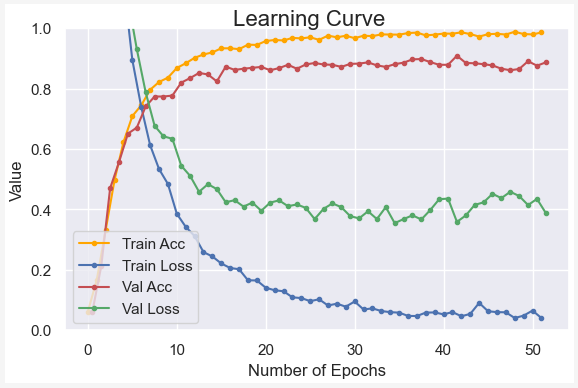

In [91]:
plot_history(history_drop2)

### #3 dropout rate = 0.4,0.4,0.4

In [92]:
def model_d3(hiddensizes, actfn, optimizer, learningrate=0):
    
    model = keras.models.Sequential()
    
    # input layer goes into this 2D convolution
    model.add(keras.layers.Conv2D(filters= 64, kernel_size=(3,3), strides=(2,2), activation=actfn, padding="same",kernel_initializer="he_uniform", 
                                  input_shape=[28, 28, 1]))    
     # Pool (downsize)
    model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))         
    
    # Dropout
    model.add(keras.layers.Dropout(rate=0.4))    
    
    # 2nd Conv
    model.add(keras.layers.Conv2D(filters = 128, kernel_size=(3,3), strides= 2, padding="same", activation=actfn,kernel_initializer="he_uniform")) 
    # Pool (downsize)
    model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
    
    # Dropout
    model.add(keras.layers.Dropout(rate=0.4))
    
    # 3nd Conv
    model.add(keras.layers.Conv2D(filters= 256, kernel_size=(3,3), strides= (2,2), padding="same", activation=actfn,kernel_initializer="he_uniform")) 
    
    # Dropout
    model.add(keras.layers.Dropout(rate=0.4))
    
    # unravel into a 1D vector
    model.add(keras.layers.Flatten())                         

    model.add(keras.layers.Dense(25, activation = "softmax")) 
    model.compile(loss="categorical_crossentropy", optimizer=optimizer(lr=learningrate), metrics=["accuracy"]) 
    return model

valacc, testacc, history_drop3, model_drop3 = do_all2(model_d3,[64,128,256], actfn, optimizer, learningrate, n_train, n_valid,
                                                80,batch_size)

Epoch 1/80
79/79 [==============================] - 1s 17ms/step - loss: 3.6230 - accuracy: 0.0496 - val_loss: 3.1513 - val_accuracy: 0.0330
Epoch 2/80
79/79 [==============================] - 1s 16ms/step - loss: 3.2092 - accuracy: 0.0932 - val_loss: 2.8189 - val_accuracy: 0.1620
Epoch 3/80
79/79 [==============================] - 1s 16ms/step - loss: 2.7672 - accuracy: 0.1704 - val_loss: 2.3349 - val_accuracy: 0.2590
Epoch 4/80
79/79 [==============================] - 1s 16ms/step - loss: 2.2140 - accuracy: 0.3088 - val_loss: 1.7842 - val_accuracy: 0.4900
Epoch 5/80
79/79 [==============================] - 1s 16ms/step - loss: 1.7379 - accuracy: 0.4508 - val_loss: 1.4381 - val_accuracy: 0.5680
Epoch 6/80
79/79 [==============================] - 1s 16ms/step - loss: 1.4245 - accuracy: 0.5352 - val_loss: 1.2091 - val_accuracy: 0.5800
Epoch 7/80
79/79 [==============================] - 1s 16ms/step - loss: 1.1582 - accuracy: 0.6224 - val_loss: 1.0286 - val_accuracy: 0.6480
Epoch 8/80
79

In [93]:
testres = model_drop3.evaluate(X_valid, y_valid, verbose=0)

print("Valid set")
print('loss, accuracy:', testres)

Valid set
loss, accuracy: [0.29386261105537415, 0.9240000247955322]


In [94]:
testres = model_drop3.evaluate(X_test, y_test, verbose=0)

print("Test set")
print('loss, accuracy:', testres)

Test set
loss, accuracy: [0.3792192041873932, 0.9139999747276306]


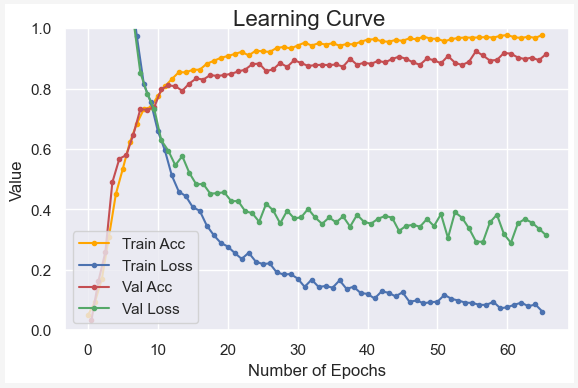

In [95]:
plot_history(history_drop3)

### #4 dropout rate = 0.4,0.45,0.45

In [128]:
def model_d4(hiddensizes, actfn, optimizer, learningrate=0):
    
    model = keras.models.Sequential()
    
    # input layer goes into this 2D convolution
    model.add(keras.layers.Conv2D(filters= 64, kernel_size=(3,3), strides=(2,2), activation=actfn, padding="same",kernel_initializer="he_uniform", 
                                  input_shape=[28, 28, 1]))    
    # Pool (downsize)
    model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))         
    
    # Dropout
    model.add(keras.layers.Dropout(rate=0.4))    
    
    # 2nd Conv
    model.add(keras.layers.Conv2D(filters = 128, kernel_size=(3,3), strides= 2, padding="same", activation=actfn,kernel_initializer="he_uniform")) 
    # Pool (downsize)
    model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
    
    # Dropout
    model.add(keras.layers.Dropout(rate=0.45))
    
    # 3nd Conv
    model.add(keras.layers.Conv2D(filters= 256, kernel_size=(3,3), strides= (2,2), padding="same", activation=actfn,kernel_initializer="he_uniform")) 
    
    # Dropout
    model.add(keras.layers.Dropout(rate=0.45))
    
    # unravel into a 1D vector
    model.add(keras.layers.Flatten())                         

    model.add(keras.layers.Dense(25, activation = "softmax")) 
    model.compile(loss="categorical_crossentropy", optimizer=optimizer(lr=learningrate), metrics=["accuracy"]) 
  
    return model

valacc, testacc, history_drop4, model_drop4 = do_all2(model_d4,[64,128,256], actfn, optimizer, learningrate, n_train, n_valid,
                                                80,batch_size)

Epoch 1/80
79/79 [==============================] - 1s 17ms/step - loss: 3.6910 - accuracy: 0.0416 - val_loss: 3.1727 - val_accuracy: 0.0270
Epoch 2/80
79/79 [==============================] - 1s 16ms/step - loss: 3.3091 - accuracy: 0.0748 - val_loss: 2.9192 - val_accuracy: 0.1320
Epoch 3/80
79/79 [==============================] - 1s 16ms/step - loss: 2.9479 - accuracy: 0.1452 - val_loss: 2.5574 - val_accuracy: 0.2310
Epoch 4/80
79/79 [==============================] - 1s 17ms/step - loss: 2.4756 - accuracy: 0.2324 - val_loss: 2.0110 - val_accuracy: 0.4060
Epoch 5/80
79/79 [==============================] - 1s 15ms/step - loss: 2.0719 - accuracy: 0.3504 - val_loss: 1.6653 - val_accuracy: 0.4770
Epoch 6/80
79/79 [==============================] - 1s 16ms/step - loss: 1.6882 - accuracy: 0.4588 - val_loss: 1.4519 - val_accuracy: 0.5660
Epoch 7/80
79/79 [==============================] - 1s 15ms/step - loss: 1.4333 - accuracy: 0.5332 - val_loss: 1.1876 - val_accuracy: 0.6420
Epoch 8/80
79

In [129]:
testres = model_drop4.evaluate(X_test, y_test, verbose=0)

print("Test set")
print('loss, accuracy:', testres)

Test set
loss, accuracy: [0.3909469544887543, 0.890999972820282]


In [130]:
testres = model_drop4.evaluate(X_valid, y_valid, verbose=0)

print("Valid set")
print('loss, accuracy:', testres)

Valid set
loss, accuracy: [0.3409038186073303, 0.9089999794960022]


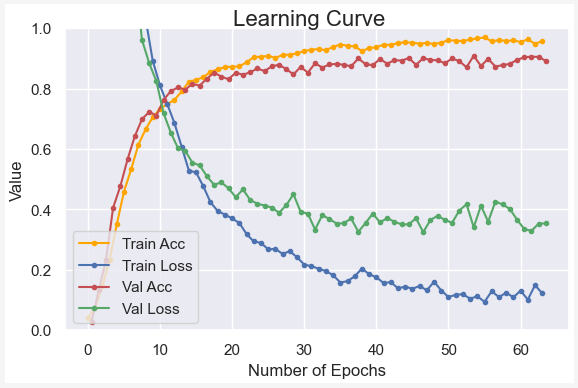

In [131]:
plot_history(history_drop4)

### #5 dropout rate = 0.2,0.45,0.45

In [100]:
def model_d5(hiddensizes, actfn, optimizer, learningrate=0):
    
    model = keras.models.Sequential()
    
    # input layer goes into this 2D convolution
    model.add(keras.layers.Conv2D(filters= 64, kernel_size=(3,3), strides=(2,2), activation=actfn, padding="same",kernel_initializer="he_uniform", 
                                  input_shape=[28, 28, 1]))    
     # Pool (downsize)
    model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))         
    
    # Dropout
    model.add(keras.layers.Dropout(rate=0.2))    
    
    # 2nd Conv
    model.add(keras.layers.Conv2D(filters = 128, kernel_size=(3,3), strides= 2, padding="same", activation=actfn,kernel_initializer="he_uniform")) 
    # Pool (downsize)
    model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
    
    # Dropout
    model.add(keras.layers.Dropout(rate=0.4))
    
    # 3nd Conv
    model.add(keras.layers.Conv2D(filters= 256, kernel_size=(3,3), strides= (2,2), padding="same", activation=actfn,kernel_initializer="he_uniform")) 
    
    # Dropout
    model.add(keras.layers.Dropout(rate=0.4))
    
    # unravel into a 1D vector
    model.add(keras.layers.Flatten())                         

    model.add(keras.layers.Dense(25, activation = "softmax")) 
    model.compile(loss="categorical_crossentropy", optimizer=optimizer(lr=learningrate), metrics=["accuracy"]) 
  
    return model

valacc, testacc, history_drop5, model_drop5 = do_all2(model_d5,[64,128,256], actfn, optimizer, learningrate, n_train, n_valid,
                                                80,batch_size)

Epoch 1/80
79/79 [==============================] - 1s 18ms/step - loss: 3.4583 - accuracy: 0.0596 - val_loss: 3.0277 - val_accuracy: 0.1060
Epoch 2/80
79/79 [==============================] - 1s 16ms/step - loss: 2.8048 - accuracy: 0.1724 - val_loss: 2.1915 - val_accuracy: 0.2960
Epoch 3/80
79/79 [==============================] - 1s 17ms/step - loss: 2.0941 - accuracy: 0.3352 - val_loss: 1.6967 - val_accuracy: 0.4670
Epoch 4/80
79/79 [==============================] - 1s 16ms/step - loss: 1.5920 - accuracy: 0.4768 - val_loss: 1.2574 - val_accuracy: 0.6290
Epoch 5/80
79/79 [==============================] - 1s 16ms/step - loss: 1.2304 - accuracy: 0.5944 - val_loss: 1.0837 - val_accuracy: 0.6540
Epoch 6/80
79/79 [==============================] - 1s 16ms/step - loss: 1.0101 - accuracy: 0.6608 - val_loss: 0.9250 - val_accuracy: 0.6850
Epoch 7/80
79/79 [==============================] - 1s 16ms/step - loss: 0.8166 - accuracy: 0.7244 - val_loss: 0.8186 - val_accuracy: 0.7070
Epoch 8/80
79

In [101]:
testres = model_drop5.evaluate(X_valid, y_valid, verbose=0)

print("Valid set")
print('loss, accuracy:', testres)

Valid set
loss, accuracy: [0.36727988719940186, 0.8960000276565552]


In [102]:
testres = model_drop5.evaluate(X_test, y_test, verbose=0)

print("Test set")
print('loss, accuracy:', testres)

Test set
loss, accuracy: [0.4516848921775818, 0.8840000033378601]


### #5 Batch normalisation (only)

In [103]:
def model_b1(hiddensizes, actfn, optimizer, learningrate=0):
    
    model = keras.models.Sequential()
    
    # input layer goes into this 2D convolution
    model.add(keras.layers.Conv2D(filters= 64, kernel_size=(3,3), strides=(2,2), activation=actfn, padding="same",kernel_initializer="he_uniform", 
                                  input_shape=[28, 28, 1]))    
     # Pool (downsize)
    model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))   
    
    # Norm
    model.add(keras.layers.BatchNormalization())  
    
    # 2nd Conv
    model.add(keras.layers.Conv2D(filters = 128, kernel_size=(3,3), strides= 2, padding="same", activation=actfn,kernel_initializer="he_uniform")) 
    # Pool (downsize)
    model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
    
    # Norm
    model.add(keras.layers.BatchNormalization())  
    
    # 3nd Conv
    model.add(keras.layers.Conv2D(filters= 256, kernel_size=(3,3), strides= (2,2), padding="same", activation=actfn,kernel_initializer="he_uniform")) 
    
    # Norm
    model.add(keras.layers.BatchNormalization())  
    
    # unravel into a 1D vector
    model.add(keras.layers.Flatten())                         

    model.add(keras.layers.Dense(25, activation = "softmax")) 
    model.compile(loss="categorical_crossentropy", optimizer=optimizer(lr=learningrate), metrics=["accuracy"]) 
    
    return model

valacc, testacc, history_bh1, model_bh1 = do_all2(model_b1,[64,128,256], actfn, optimizer, learningrate, n_train, n_valid,
                                                80,batch_size)

Epoch 1/80
79/79 [==============================] - 1s 18ms/step - loss: 1.2748 - accuracy: 0.6412 - val_loss: 2.9338 - val_accuracy: 0.1240
Epoch 2/80
79/79 [==============================] - 1s 16ms/step - loss: 0.2235 - accuracy: 0.9524 - val_loss: 3.4076 - val_accuracy: 0.1430
Epoch 3/80
79/79 [==============================] - 1s 16ms/step - loss: 0.0829 - accuracy: 0.9872 - val_loss: 2.2174 - val_accuracy: 0.3750
Epoch 4/80
79/79 [==============================] - 1s 17ms/step - loss: 0.0311 - accuracy: 0.9992 - val_loss: 1.2632 - val_accuracy: 0.5950
Epoch 5/80
79/79 [==============================] - 1s 17ms/step - loss: 0.0156 - accuracy: 1.0000 - val_loss: 0.8356 - val_accuracy: 0.7280
Epoch 6/80
79/79 [==============================] - 1s 17ms/step - loss: 0.0105 - accuracy: 1.0000 - val_loss: 0.5694 - val_accuracy: 0.8300
Epoch 7/80
79/79 [==============================] - 1s 17ms/step - loss: 0.0106 - accuracy: 0.9996 - val_loss: 0.4915 - val_accuracy: 0.8590
Epoch 8/80
79

In [104]:
testres = model_drop5.evaluate(X_valid, y_valid, verbose=0)

print("Valid set")
print('loss, accuracy:', testres)

Valid set
loss, accuracy: [0.36727988719940186, 0.8960000276565552]


In [105]:
testres = model_drop5.evaluate(X_test, y_test, verbose=0)

print("Test set")
print('loss, accuracy:', testres)

Test set
loss, accuracy: [0.4516848921775818, 0.8840000033378601]


### #6 Batch normalisation and drop (apply normalisation before max pooling)

In [106]:
def model_drop_norm(hiddensizes, actfn, optimizer, learningrate=0):
    
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(filters= 64, kernel_size=(3,3), strides=(2,2), activation=actfn, padding="same",
                                  kernel_initializer="he_uniform", input_shape=[28, 28, 1])) 
    # Batch normalisation
    model.add(keras.layers.BatchNormalization())
    
    # Pool (downsize) 
    model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
    
    # Dropout 
    model.add(keras.layers.Dropout(rate=0.35))  
        
    model.add(keras.layers.Conv2D(filters = 128, kernel_size=(3,3), strides= 2, padding="same", activation=actfn,kernel_initializer="he_uniform")) 
    
    # Batch normalisation
    model.add(keras.layers.BatchNormalization())
    
    # Pool (downsize) 
    model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))          
    
    model.add(keras.layers.Conv2D(filters= 256, kernel_size=(3,3), strides= (2,2), padding="same", activation=actfn,kernel_initializer="he_uniform"))
    
    # Batch normalisation
    model.add(keras.layers.BatchNormalization())
    
    # Dropout
    model.add(keras.layers.Dropout(rate=0.45))
       
    # unravel into a 1D vector
    model.add(keras.layers.Flatten())                         

    model.add(keras.layers.Dense(25, activation = "softmax")) 
    model.compile(loss="categorical_crossentropy", optimizer=optimizer(lr=learningrate), metrics=["accuracy"]) 
  
    return model

valacc, testacc, history_d_n, model_d_n = do_all2(model_drop_norm,[64,128,256], actfn, optimizer, learningrate, n_train, n_valid,
                                                80,batch_size)

Epoch 1/80
79/79 [==============================] - 2s 29ms/step - loss: 2.7747 - accuracy: 0.2688 - val_loss: 2.6527 - val_accuracy: 0.2290
Epoch 2/80
79/79 [==============================] - 2s 22ms/step - loss: 1.3909 - accuracy: 0.5592 - val_loss: 1.9875 - val_accuracy: 0.3920
Epoch 3/80
79/79 [==============================] - 2s 21ms/step - loss: 0.8894 - accuracy: 0.7164 - val_loss: 1.3983 - val_accuracy: 0.5560
Epoch 4/80
79/79 [==============================] - 2s 21ms/step - loss: 0.6419 - accuracy: 0.7852 - val_loss: 1.0277 - val_accuracy: 0.6650
Epoch 5/80
79/79 [==============================] - 2s 22ms/step - loss: 0.4961 - accuracy: 0.8480 - val_loss: 0.8007 - val_accuracy: 0.7270
Epoch 6/80
79/79 [==============================] - 2s 22ms/step - loss: 0.4139 - accuracy: 0.8592 - val_loss: 0.5969 - val_accuracy: 0.7920
Epoch 7/80
79/79 [==============================] - 2s 21ms/step - loss: 0.3088 - accuracy: 0.9068 - val_loss: 0.5945 - val_accuracy: 0.8170
Epoch 8/80
79

In [107]:
testres = model_d_n.evaluate(X_valid, y_valid, verbose=0)

print("Valid set")
print('loss, accuracy:', testres)

Valid set
loss, accuracy: [0.35480964183807373, 0.8930000066757202]


In [108]:
testres = model_d_n.evaluate(X_test, y_test, verbose=0)

print("Test set")
print('loss, accuracy:', testres)

Test set
loss, accuracy: [0.4190017879009247, 0.8840000033378601]


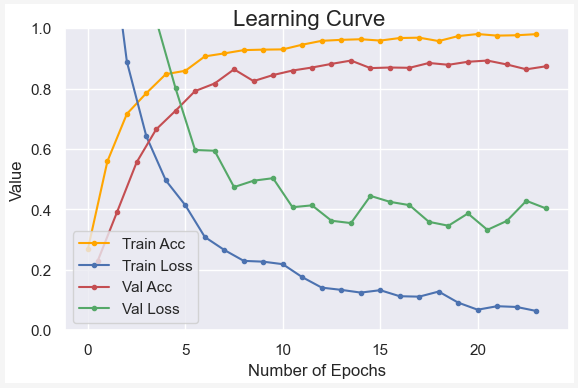

In [109]:
plot_history(history_d_n)

### #6 Batch normalisation and drop (apply normalisation after max pooling)

In [110]:
def model_drop_norm2(hiddensizes, actfn, optimizer, learningrate=0):
    
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(filters= 64, kernel_size=(3,3), strides=(2,2), activation=actfn, padding="same",kernel_initializer="he_uniform", 
                                  input_shape=[28, 28, 1]))    # input layer goes into this 2D convolution
    # Pool (downsize)
    model.add(keras.layers.MaxPooling2D(pool_size=(2,2))) 
    # Norm
    model.add(keras.layers.BatchNormalization(momentum = 0.99))
    # Drop
    model.add(keras.layers.Dropout(rate=0.35))  

    # 2nd Conv
    model.add(keras.layers.Conv2D(filters = 128, kernel_size=(3,3), strides= 2, padding="same", activation=actfn,kernel_initializer="he_uniform"))     
    # Pool (downsize)
    model.add(keras.layers.MaxPooling2D(pool_size=(2,2))) 
    # Norm
    model.add(keras.layers.BatchNormalization(momentum = 0.99))
    # Drop
    model.add(keras.layers.Dropout(rate=0.45))
    
    # 3nd Conv
    model.add(keras.layers.Conv2D(filters= 256, kernel_size=(3,3), strides= (2,2), padding="same", activation=actfn,kernel_initializer="he_uniform")) 
    # Norm
    model.add(keras.layers.BatchNormalization(momentum = 0.99))
    # Drop
    model.add(keras.layers.Dropout(rate=0.45))
       
    # unravel into a 1D vector
    model.add(keras.layers.Flatten())                         

    model.add(keras.layers.Dense(25, activation = "softmax"))  # always have 10 classes
    model.compile(loss="categorical_crossentropy", optimizer=optimizer(lr=learningrate), metrics=["accuracy"]) 
  
    return model

valacc, testacc, history_d_n2, model_d_n2 = do_all2(model_drop_norm2,[64,128,256], actfn, optimizer, learningrate, n_train, n_valid,
                                                80,batch_size)

Epoch 1/80
79/79 [==============================] - 2s 20ms/step - loss: 3.2157 - accuracy: 0.1884 - val_loss: 2.7830 - val_accuracy: 0.1820
Epoch 2/80
79/79 [==============================] - 1s 19ms/step - loss: 1.8930 - accuracy: 0.4312 - val_loss: 2.8254 - val_accuracy: 0.2010
Epoch 3/80
79/79 [==============================] - 1s 18ms/step - loss: 1.3454 - accuracy: 0.5808 - val_loss: 2.3635 - val_accuracy: 0.3510
Epoch 4/80
79/79 [==============================] - 1s 18ms/step - loss: 1.0918 - accuracy: 0.6468 - val_loss: 1.7103 - val_accuracy: 0.4880
Epoch 5/80
79/79 [==============================] - 1s 18ms/step - loss: 0.8685 - accuracy: 0.7256 - val_loss: 1.0846 - val_accuracy: 0.6410
Epoch 6/80
79/79 [==============================] - 1s 18ms/step - loss: 0.7669 - accuracy: 0.7484 - val_loss: 0.8039 - val_accuracy: 0.7280
Epoch 7/80
79/79 [==============================] - 1s 18ms/step - loss: 0.6608 - accuracy: 0.7804 - val_loss: 0.6156 - val_accuracy: 0.8060
Epoch 8/80
79

In [111]:
testres = model_d_n2.evaluate(X_valid, y_valid, verbose=0)

print("Valid set")
print('loss, accuracy:', testres)

Valid set
loss, accuracy: [0.3729131817817688, 0.9010000228881836]


In [112]:
testres = model_d_n2.evaluate(X_test, y_test, verbose=0)

print("Test set")
print('loss, accuracy:', testres)

Test set
loss, accuracy: [0.3932766616344452, 0.878000020980835]


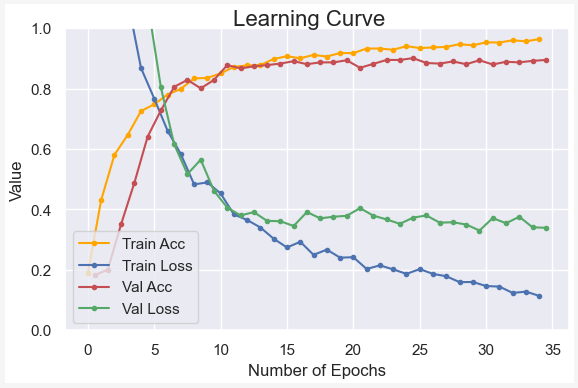

In [113]:
plot_history(history_d_n2)

#### Summary
1.

- The hyperparameter dropout rate is usually set between 0.1 and 0.5 and close to 0.4 – 0.5 in convolutional neural networks.
- Therefore i set dropout rates between 0.2 to 0.45

- I found highest accuracy and lowest loss for dropout rates 0.4,0.4,0.4 in the the layers 64,128,256 respectively for both the test set and validationset. The accuracy and loss are mentioned below.

- best loss, accuracy for test set :       0.3792192041873932,  0.9139999747276306
- best loss, accuracy for validation set : 0.29386261105537415, 0.9240000247955322

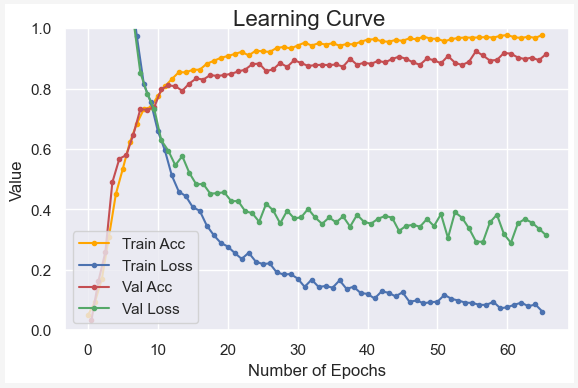

In [132]:
#training and validation accuracy and loss plot  for dropout rates 0.4,0.4,0.4
plot_history(history_drop3)

2.

- For batch normalisation, i tried to apply it before and after max pooling layer
- It can take two parameters axis and momemtum. I chose default value for axis and momemtum is usually chosen close to 1 so i chose 0.99.
- For my neural network model, batch normalisation after max pooling layer shows a slightly higher accuracy


- batch normalisation after max pooling, loss and accuracy for test set :       0.3932766616344452, 0.878000020980835
- batch normalisation after max pooling, loss and accuracy for validation set : 0.3729131817817688, 0.9010000228881836

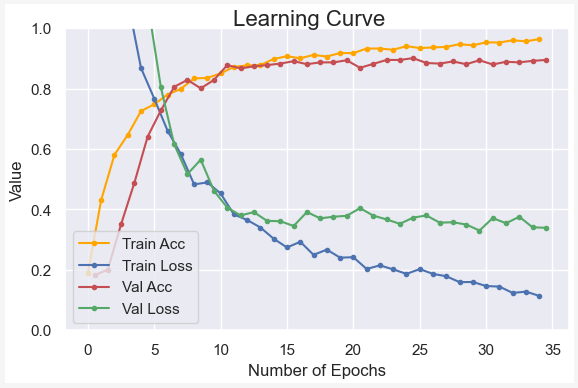

In [115]:
#training and validation accuracy and loss plot for batch normalisation after max pooling layer
plot_history(history_d_n2)

- Therefore my neural network performs better after using dropouts when compared to applying both normalisation and dropouts


- The best performance for my CNN model was with only dropouts and has an accuracy of approximately 92.4% and  loss of about 29.38% .


***